#### Воспроизвести обучение сейчас невозможно так как отсутствуют данные из трех источников:
#### обучение валидирование тест и прогнозирование
#### Продемонстрировать все - невозможно из за обработки персональных данных и отсутствия доступа ко всем источникам
#### Данная работа лишь черновик, того, что использовалось автором и результат чего внедрен в прод.
#### пример данных в папке /dst

### В комментариях мои пояснения

In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import  f1_score, accuracy_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
from datetime import datetime

import sys
import os
pd.options.mode.chained_assignment = None  # default='warn'

In [1]:
ud = ['f1r3_3']

data = ['f1r5r2','f1r11r2','f1r12r1']  #zayav-kusp,  vozb-UD, soversh_prest

text = ['f1r12r3']

punkt = ['f1r13r2'] #use concat st.ch # 'f1r13_1r3g1', 'f1r13_1r3g2', 'f1r13_1r3g3'

cat = [ 'region','f1r1r1','f1r1r2','f1r2','f1r3r1','f1r3r2',
'f1r3r3','f1r8','f1r9','f1r9_1g1','f1r9_1g2','f1r10','f1r10_1','f1r10_2','f1r10_3','f1r11r1','f1r12r2','f1r13r1',
'f1r15','f1r16','f1r17','f1r18','f1r19','f1r19_1','f1r20','f1r21','f1r21_1','f1r22',
'f1r23g1','f1r23g2','f1r23g3','f1r23_1g1','f1r23_1g2','f1r23_1g3','f1r24g1','f1r24g2','f1r24g3',
'f1r25_1r1g1','f1r25_1r1g2','f1r25_1r1g3','f1r25_1r1g4','f1r25_1r1g5','f1r25_1r1g6','f1r25_1r1g7','f1r25_1r1g8','f1r25_1r1g9','f1r25_2r1g1','f1r25_2r1g2',
'f1r25_2r1g3',
'f1r26g1','f1r26g2','f1r26g3','f1r26g4','f1r26g5','f1r26g6','f1r27g1','f1r27g2','f1r27g3','f1r27g4','f1r27g5','f1r27g6','f1r28g1',
'f1r28g2','f1r28g3','f1r28g4','f1r28g5','f1r29','f1r29_1g1','f1r29_1g2','f1r29_1g3','f1r29_1g4','f1r32r2','f1r33g1',
'f1r33g2','f1r33g3','f1r33g4','f1r33g5','f1r34g1','f1r34g2','f1r34g3','f1r34g4','f1r35g1','f1r35g2','f1r36g1','f1r36g2',
'f1r37g1','f1r37g2','f1r40']

kol = ['f1r4',
	'f1r25r2g1','f1r25r2g2','f1r25r2g3',
	'f1r25r2g4','f1r25_1r2g1','f1r25_1r2g2','f1r25_1r2g3',
	'f1r25_1r2g4','f1r25_1r2g5','f1r25_1r2g6','f1r25_1r2g7',
	'f1r25_1r2g8','f1r25_1r2g9','f1r25_2r2g1','f1r25_2r2g2',
	'f1r25_2r2g3',	'f1r30_1',	'f1r30_2',
	'f1r30_4',	'f1r30_7',
	'f1r30_9',	'f1r30_10',	'f1r31']

y = ['raskr']

cols= data + text + punkt + cat + kol+ y + ud

In [3]:
###Функции для перемещения дат в необходимые столбцы после извлечения из фабул, для пустых значений

def replacer0(col_from:str, col_to:str) -> None:    
    idx = df[df[col_to].isnull() == True].index
    df[col_to].iloc[idx] = df[col_from].iloc[idx]
    
def replacer1(col_from:str, col_to:str) -> None:    
    mean_diff = (df[col_from].dropna() - df[col_to].dropna()).dropna().median() + pd.Timedelta(days=1)
    idx = df[df[col_to].isnull() == True].index
    df[col_to].iloc[idx] = df[col_from].iloc[idx] - mean_diff
    
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # исходим из предположения о том, что если это не DataFrame, то это Series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # преобразуем байты в мегабайты
    return "{:03.2f} MB".format(usage_mb)

In [4]:
%%time

region_list = [1101,1103,1104,1105,1106,1107,1108,1109,1110,1111,1112,1114,1115,
1117,1118,1119,1120,1122,1124,1125,1127,1128,1129,1130,1132,1133,1134,1136,1137,
1138,1140,1142,1144,1145,1146,1147,1149,1150,1151,1152,1153,1154,1156,1157,1158,
1160,1161,1162,1163,1164,1165,1166,1168,1169,1170,1171,1172,1173,1174,1175,1176,
1177,1178,1179,1180,1181,1182,1183,1184,1185,1186,1187,1188,1189,1190,1191,1192,
1193,1194,1195,1196,1197,1198,1199,6101,6113,6115,6117,6118,6119,6120,6122,6123,6204]

df_list = []

for i in region_list:
    path1 = '/V11/prognoz/model/prod/dsts/files_learn_full/' + 'r{}learn.csv'.format(i) # В файлах полное количество записей 
    path2 = '/V11/prognoz/model/prod/dsts/files_2020/' + 'r{}rn.csv'.format(i) # выборка раскрытых и нераскрытых за 2020 г
    path3 = '/V11/prognoz/model/prod/dsts/ner202106/' + 'r{}ner6.csv'.format(i) ## нераскрытые по состоянию на 1 полугодие  2021
    path4 = '/V11/prognoz/model/prod/dsts/files_202106_all/' + 'r{}learn.csv'.format(i) # нераскрытые + раскрытые по состоянию на 1 полугодие  2021
    path5 = '/V11/prognoz/model/prod/dsts/files_20210809/' + 'r{}learn2.csv'.format(i) # до 2020 ППЛ с проставленным раскрытием  трейн
    path5n = '/V11/prognoz/model/prod/dsts/files_20210809/' + 'r{}ner8.csv'.format(i) # до 2020 ППЛ с проставленным раскрытием  тест (фор предикт)
    path6 = '/V11/prognoz/model/prod/dsts/20.09.2021/' + 'r{}ner10raskr.csv'.format(i)  #ППЛ, раскрытые на 20.09.2021 г.
    path7 = '/V11/prognoz/model/prod/dsts/files_10_2/' + 'r{}ner10raskr.csv'.format(i) #все ППЛ, в тч раскрытые на 13.12.2021 г.
    
    try:
        df_list.append(pd.read_csv(path1, sep = ',', quotechar='\'',  encoding='cp1251', usecols = cols, low_memory=False))
    except ValueError:
        cols= data +  punkt + cat + kol+ y + ud
        df_list.append(pd.read_csv(path1, sep = ',', quotechar='\'',  encoding='cp1251', usecols = cols, low_memory=False))

df = pd.concat(df_list)
df.reset_index(inplace = True)
df = df.drop(columns = ['index'])
df_list.clear()

for i in data:
    df[i] = pd.to_datetime(df[i], format="%d.%m.%Y", errors='coerce')


CPU times: user 4min 56s, sys: 1min 7s, total: 6min 3s
Wall time: 6min 4s


In [5]:
# Размер обучающего массива  14,5млн., соотношение раскрываемости(1-раскрыто, 0-нет), 
# количество регионов в датасете

trn = df.copy()
print(trn.shape)
print(trn.raskr.value_counts())
print('kol regionov: ', len(list(trn.region.unique())))

(14523435, 119)
1    8002054
0    6521381
Name: raskr, dtype: int64
kol regionov:  94


In [6]:
# Читаем сведения для валидационной выборки - данные более свежего года

%%time

df_list = []

for i in region_list:
    path1 = '/V11/prognoz/model/prod/dsts/files_learn_full/' + 'r{}learn.csv'.format(i) # В файлах полное количество записей 
    path2 = '/V11/prognoz/model/prod/dsts/files_2020/' + 'r{}rn.csv'.format(i) # выборка раскрытых и нераскрытых за 2020 г
    path3 = '/V11/prognoz/model/prod/dsts/ner202106/' + 'r{}ner6.csv'.format(i) ## нераскрытые по состоянию на 1 полугодие  2021
    path4 = '/V11/prognoz/model/prod/dsts/files_202106_all/' + 'r{}learn.csv'.format(i) # нераскрытые + раскрытые по состоянию на 1 полугодие  2021
    path5 = '/V11/prognoz/model/prod/dsts/files_20210809/' + 'r{}learn2.csv'.format(i) # до 2020 ППЛ с проставленным раскрытием  трейн
    path5n = '/V11/prognoz/model/prod/dsts/files_20210809/' + 'r{}ner8.csv'.format(i) # до 2020 ППЛ с проставленным раскрытием  тест (фор предикт)
    path6 = '/V11/prognoz/model/prod/dsts/20.09.2021/' + 'r{}ner10raskr.csv'.format(i)  #ППЛ, раскрытые на 20.09.2021 г.
    path7 = '/V11/prognoz/model/prod/dsts/files_10_2/' + 'r{}ner10raskr.csv'.format(i) #все ППЛ, в тч раскрытые на 13.12.2021 г.
    try:
        df_list.append(pd.read_csv(path2, sep = ',', quotechar='\'',  encoding='cp1251', usecols = cols, low_memory=False))
    except ValueError:
        cols= data +  punkt + cat + kol+ y + ud
        df_list.append(pd.read_csv(path2, sep = ',', quotechar='\'',  encoding='cp1251', usecols = cols, low_memory=False))

df = pd.concat(df_list)
df.reset_index(inplace = True)
df = df.drop(columns = ['index'])
df_list.clear()

for i in data:
    df[i] = pd.to_datetime(df[i], format="%d.%m.%Y", errors='coerce')

CPU times: user 33.4 s, sys: 3.44 s, total: 36.8 s
Wall time: 36.8 s


In [7]:
# Размер валид. массива 2млн., соотношение раскрываемости(1-раскрыто, 0-нет), 
# количество регионов в датасете

tst = df.copy()
print(tst.shape)
print(tst.raskr.value_counts())
print('kol regionov: ', len(list(tst.region.unique())))

(1965511, 119)
1    1020333
0     945178
Name: raskr, dtype: int64
kol regionov:  94


In [8]:
# Читаем данные для теста- еще более свежие.

%%time

df_list = []

for i in region_list:
    path1 = '/V11/prognoz/model/prod/dsts/files_learn_full/' + 'r{}learn.csv'.format(i) # В файлах полное количество записей 
    path2 = '/V11/prognoz/model/prod/dsts/files_2020/' + 'r{}rn.csv'.format(i) # выборка раскрытых и нераскрытых за 2020 г
    path3 = '/V11/prognoz/model/prod/dsts/ner202106/' + 'r{}ner6.csv'.format(i) ## нераскрытые по состоянию на 1 полугодие  2021
    path4 = '/V11/prognoz/model/prod/dsts/files_202106_all/' + 'r{}learn.csv'.format(i) # нераскрытые + раскрытые по состоянию на 1 полугодие  2021
    path5 = '/V11/prognoz/model/prod/dsts/files_20210809/' + 'r{}learn2.csv'.format(i) # до 2020 ППЛ с проставленным раскрытием  трейн
    path5n = '/V11/prognoz/model/prod/dsts/files_20210809/' + 'r{}ner8.csv'.format(i) # до 2020 ППЛ с проставленным раскрытием  тест (фор предикт)
    path6 = '/V11/prognoz/model/prod/dsts/20.09.2021/' + 'r{}ner10raskr.csv'.format(i)  #ППЛ, раскрытые на 20.09.2021 г.
    path7 = '/V11/prognoz/model/prod/dsts/files_10_2/' + 'r{}ner10raskr.csv'.format(i) #все ППЛ, в тч раскрытые на 13.12.2021 г.
    try:
        df_list.append(pd.read_csv(path7, sep = ',', quotechar='\'',  encoding='cp1251', usecols = cols, low_memory=False))
    except ValueError:
        cols= data +  punkt + cat + kol+ y + ud
        df_list.append(pd.read_csv(path7, sep = ',', quotechar='\'',  encoding='cp1251', usecols = cols, low_memory=False))

df = pd.concat(df_list)
df.reset_index(inplace = True)
df = df.drop(columns = ['index'])
df_list.clear()

for i in data:
    df[i] = pd.to_datetime(df[i], format="%d.%m.%Y", errors='coerce')


CPU times: user 1.68 s, sys: 3.92 ms, total: 1.68 s
Wall time: 1.68 s


In [9]:
# Размер ТЕСТОВОГО массива 50к, соотношение раскрываемости(1-раскрыто, 0-нет), 
# количество регионов в датасете


# Я знаю что распределение в данных для прогноза должно быть таким же как и при обучении
# ЦЕЛЬ построить устойчивую модель к любым данным, и это получилось! 

tst21 = df.copy()
print(tst21.shape)
print(tst21.raskr.value_counts())
print('kol regionov: ', len(list(tst21.region.unique())))

(47903, 118)
1    47903
Name: raskr, dtype: int64
kol regionov:  93


In [10]:
# Проверим объем памяти, 
# CATBOOST разгоняет данные во время обучения в 10-12 раз 
#(при найденных и оптимальных для нас параметрах) на сервере 450Гб Оперативы, 
# и даже этого не хватало, пока я не научился экономить память

for df in [trn,tst,tst21]: #tst21,trn20
    print(df.shape)
    print(mem_usage(df), end='\n\n')

(14523435, 119)
19404.08 MB

(1965511, 119)
2777.55 MB

(47903, 118)
51.82 MB



In [12]:
# Взгляним практически на GOLDEN FEATURES
# даты ЗАЯВЛЕНИЯ ПОТЕРПЕВШЕГО,  ВОЗБУЖДЕНИЯ ДЕЛА, СОВЕРШЕНИЯ ПРЕСТУПЛЕНИЯ
trn[data].tail(14)

,f1r5r2,f1r11r2,f1r12r1
14523421,2013-06-19,2013-08-23,2013-06-19
14523422,2013-07-05,2013-08-26,2013-07-05
14523423,2013-08-27,2013-08-28,2013-08-27
14523424,2012-12-05,2012-12-17,2012-08-10
14523425,2012-12-05,2012-12-17,2012-09-06
14523426,2012-12-05,2012-12-17,2012-09-18
14523427,2012-12-05,2012-12-11,2012-07-13
14523428,2012-12-06,2012-12-17,2012-08-09
14523429,2012-12-06,2012-12-17,2012-07-02
14523430,2012-12-06,2012-12-17,2012-08-10


In [13]:
#  Предобработаем данные 
# Протестировано не менее сотни гипотез
# и столько же новых синтезированных признаков- 
# что использовано здесь- оно РАБОТАЕТ и зделано не просто так... 

for df in [trn, tst, tst21]: #trn,tst #tst21,trn20 ,tst21,trn20 Для всех массивов данных
    
    
    #   Удалим преступления из старого УК -ОЧЕНЬ СТАРОГО < 105 
    # 10 лет прошло и никто ничего не будет с этим делать...((
    #print(d_rand['f1r13r1'].where(d_rand['f1r13r1'] < 105000).sort_values().value_counts() )
    df.where(df['f1r13r1'] < 105000).dropna()

    #Данные в БД ООООООЧЕЕНЬ ГРЯЗНЫЕ и это не вся их очистка...
    # Часть очищал другими скриптами и фильтровал много в SQL
    
    # В данных были 1700 года python ругался на нехватку диапазона int Очищаем такие даты
    df['f1r5r2'] = df['f1r5r2'].loc[df['f1r5r2'].notna()].apply(lambda row:np.NAN if int(str(row)[:4])<1900 else row) 
    df['f1r11r2'] = df['f1r11r2'].loc[df['f1r11r2'].notna()].apply(lambda row:np.NAN if int(str(row)[:4])<1900 else row)  
    df['f1r12r1'] = df['f1r12r1'].loc[df['f1r12r1'].notna()].apply(lambda row:np.NAN if int(str(row)[:4])<1900 else row) 

    
    ## ИЗВЛЕК 200к строк дат которые не вбиты в БД но есть в описании преступления - ФАБУЛЕ
    try:
        df['f1r12r1_NEW'] = df['f1r12r3'].loc[df['f1r12r1'].isna()].str.extract(r"(\d{1,2}[/.](?:\d{1,2})[/.]\d{2}(?:\d{2})?)") # извлечение даты из фабулы для незаполненной f1r12r1 даты прест-я
        #преобразуем в тип дэттайм с разных форматов дат извлеченных из фабул
        df['f1r12r1_NEW2'] = pd.to_datetime(df['f1r12r1_NEW'],  format= "%d.%m.%y", errors ='coerce') 
        df['f1r12r1_NEW3'] = pd.to_datetime(df['f1r12r1_NEW'], format= "%d.%m.%Y",  errors ='coerce') 

        replacer0(col_from="f1r12r1_NEW2", col_to="f1r12r1") #replace to target column
        replacer0(col_from="f1r12r1_NEW3", col_to="f1r12r1")
        
        df.drop(['f1r12r3', 'f1r12r1_NEW', 'f1r12r1_NEW2', 'f1r12r1_NEW3'], axis='columns', inplace =True) # or axis=1

    except:
        print('without fabula')

    # Считаем расстояния от даты преступления до возбуждения уд\
    # от даты преступления до обращения в полицию итд 
    
    # К сожалению я считал признаки праздников предпраздничных и выходных \ длительных выходных
    #  но они плохо работали
    
    #здесь осталось только нужное
        
    df['t5-12'] = (df['f1r5r2']-df['f1r12r1']).dt.days
    df['t5-12'].fillna(df['t5-12'].loc[df['t5-12'].notna() > -1].median(), inplace=True)

    df['t11-5'] = (df['f1r11r2']-df['f1r5r2']).dt.days
    df['t11-5'].fillna(df['t11-5'].loc[df['t11-5'].notna() > -1].median(), inplace=True)

    df['t11-12'] = (df['f1r11r2']-df['f1r12r1']).dt.days
    df['t11-12'].fillna(df['t11-12'].loc[df['t11-12'].notna() > -1].median(), inplace=True)

    df[['t5-12', 't11-5', 't11-12']] = df[['t5-12', 't11-5', 't11-12']].astype(int)

    data = [ "f1r5r2", 'f1r11r2', "f1r12r1"] #zayav-kusp,  vozb-UD, soversh_prest

    # define list of attributes required    
    L = ['month', 'day', 'dayofweek', 'dayofyear', 'weekofyear']  #'quarter'

    for d in data:   #read dates
    #date_gen = (getattr(df[d].dt, i).rename(d+'-'+i) for i in L)
        for i in L:
            n = str(d)+'-'+str(i)
            df[n] = (getattr(df[d].dt, i))
            df[n].fillna(df[n].loc[df[n].notna() > -1].median(), inplace=True)
            df[n] = df[n].astype(int)

   
    df['f1r25r2'] = df['f1r25r2g1'].fillna(0).astype(int)+ \
    df['f1r25r2g2'].fillna(0).astype(int)+ \
    df['f1r25r2g3'].fillna(0).astype(int)+ \
    df['f1r25r2g4'].fillna(0).astype(int)

    df.drop(['f1r25r2g1','f1r25r2g2','f1r25r2g3','f1r25r2g4'], axis='columns', inplace =True)
   
    # СУММА УЩЕРБА- категоризируем признак а БИНЫ считаем исходя из квантилей и особенностей УК РФ
    
    
    #CREATE BINS
    # bins_money = df['f1r25r2'].loc[df['f1r25r2'] > 0].quantile([.1, .2,.3,.4,.5,.6,.7,.8,.9])
    # bins_money
    bins_money = [-1, 0, 1200, 2500, 4900, 9500, 19020, 45000, 122500, 395000, 2100000, 9999999999999]
    label_money= [0,1,2,3,4,5,6,7,8,9, 10]
    df['f1r25r2BIN'] = pd.cut(df['f1r25r2'].fillna(0).astype(int), bins = bins_money, labels = label_money)


    df['f1r25_1r2'] = df['f1r25_1r2g1'].fillna(0).astype(int) + \
    df['f1r25_1r2g2'].fillna(0).astype(int) + \
    df['f1r25_1r2g3'].fillna(0).astype(int) + \
    df['f1r25_1r2g4'].fillna(0).astype(int) + \
    df['f1r25_1r2g5'].fillna(0).astype(int) + \
    df['f1r25_1r2g6'].fillna(0).astype(int) + \
    df['f1r25_1r2g7'].fillna(0).astype(int) + \
    df['f1r25_1r2g8'].fillna(0).astype(int) + \
    df['f1r25_1r2g9'].fillna(0).astype(int)

    df.drop(['f1r25_1r2g1','f1r25_1r2g2','f1r25_1r2g3','f1r25_1r2g4','f1r25_1r2g5','f1r25_1r2g6','f1r25_1r2g7', 'f1r25_1r2g8', 'f1r25_1r2g9'], axis='columns', inplace =True)
    
    
    # ТО ЖЕ САМОЕ ВЕС НАРКОТИКОВ эх видели бы эти графики...)) Обязательно покажу если поступлю))
    
    bins_nark = [-1, 0, 1, 2, 3, 4, 8, 16, 38, 110, 441, 9999999999999]
    label_nark = [0,1,2,3,4,5,6,7,8,9,10]

    df['f1r25_1r2BIN'] = pd.cut(df['f1r25_1r2'].fillna(0).astype(int), bins = bins_nark, labels = label_nark)
    df['f1r25_1r2BIN'] = df['f1r25_1r2BIN'].fillna(0)
    #Логарифмированное распределение изъятого (веса наркотиков)
    #np.log10(df['f1r25_1r2']+1).loc[df['f1r25_1r2']>0].hist(bins=100)  # график log вес нарк..

    #df['f1r25_1r2LOG'] = np.log10(df['f1r25_1r2']+1)

    #Логарифмированное распределение изъятого (веса наркотиков)
    #np.log10(df['f1r25_1r2']+1).loc[df['f1r25_1r2']>0].hist(bins=100)

    # ТОЖЕ САМОЕ ГЕРОИН удивительно- но это отдельная категория в стат карточках 
    # ВИДИМО ГЕРОИН-не  наркотик
        
    # NEW FEATURE f1r25_2r2
    df['f1r25_2r2'] = df['f1r25_2r2g1'].fillna(0).astype(int)+ \
    df['f1r25_2r2g2'].fillna(0).astype(int)+ \
    df['f1r25_2r2g3'].fillna(0).astype(int)

    df.drop(['f1r25_2r2g1', 'f1r25_2r2g2', 'f1r25_2r2g3'], axis='columns', inplace =True)
    
    bins_ger= [-1, 0, 110, 400, 660, 900, 1400, 2550, 3310, 4920, 21922, 9999999999999]
    label_ger = [0,1,2,3,4,5,6,7,8,9,10]

    df['f1r25_2r2BIN'] = pd.cut(df['f1r25_2r2'].fillna(0).astype(int), bins = bins_ger, labels = label_ger)
    
    # Ну конечно же у нас есть 25 26 256 и 2030 часов... почему бы нет,
    # Про ограничения CONSTRAINTS на уровне СУБД - ОНИ НЕ СЛЫШАЛИ...
    # зла не хватает на этих умников-руководителей которые набирают полканов и майоров-(они ж опытные...)
    # пришлось написать несколько статей WOS и ВАК этим ученым... чтобы взяли на работу))
    
    df.loc[(df['f1r12r2']>24), 'f1r12r2'] = 30 # remove>24 
    df['f1r12r2'] = df['f1r12r2'].fillna(30).astype(int)

    #Объясняю есть СТАТЬЯ ЧАСТЬ И ПУНКТ все это кластеризует тяжесть преступления
    # И очень сложно было определить- что использовать..и как с чем комбинировать...
    #Cтатья без части 
    
    df['st'] = df['f1r13r1'] // 1000
    #df['f1r13r1'].value_counts()

    df.dropna(subset=['f1r13r1'], inplace = True)

    #  ПУНКТ СТАТЬИ ЧВ общем случае чем ближе буква к "Я"- тем хуже,
    #  БУКВ МОЖЕТ БЫТЬ НЕСКОЛЬКО и конечно все в разноброс написано... ОЧИЩАЕМ....
    
    
    #новая версия поля (верхний регистр, Сортировка букв, удаление пробелов)
    df['f1r13r2_s'] = df['f1r13r2'].loc[df['f1r13r2'].notna()].astype(str).apply(lambda x: "".upper().join(sorted(x)).lstrip().rstrip())

    #новая версия поля (верхний регистр, Сортировка букв, удаление пробелов, MAX elem)
    df['f1r13r2_max'] = df['f1r13r2'].loc[df['f1r13r2'].notna()].astype(str).apply(lambda x: max(s for s in x)) #or .apply(lambda x: x[-1])

    #df['f1r13r2_s'].value_counts().iloc[1:-1].plot()
    
    # А почему бы не брать самую последнюю букву остановившись на ней тк.. кластеров слишком много,
    # а то градиентный бустинг над решающими ЛЕСАМИ))) одуреет от инвариантности
    
    #Кодируем максимальный пункт статьи
    df['f1r13r2_max_c'] = df['f1r13r2_max'].factorize()[0]
    df.loc[df['f1r13r2_max_c'] < 0, 'f1r13r2_max_c'] = 999

    # df['f1r13r2_min'] = df['f1r13r2'].loc[df['f1r13r2'].notna()].astype(str).apply(lambda x: min(s for s in x)) #or .apply(lambda x: x[-1])
    # df['f1r13r2_min_c'] = df['f1r13r2_min'].factorize()[0]
    # df.loc[df['f1r13r2_min_c'] < 0, 'f1r13r2_min_c'] = 999

    #Кодируем сортированный словарь  пунктов статьи
    df['f1r13r2_s_c'] = df['f1r13r2_s'].factorize()[0]
    df.loc[df['f1r13r2_s_c'] < 0, 'f1r13r2_s_c'] = 999


    ## СТАТЬЯ ЧАСТЬ ПУНКТ
    df['s_ch_p'] = df['f1r13r1'].apply(int).apply(str) + df['f1r13r2_s_c'].apply(str)

    ## СТАТЬЯ ЧАСТЬ МАКС_ПУНКТ
    df['s_ch_max_p'] = df['f1r13r1'].apply(int).apply(str) + df['f1r13r2_max_c'].apply(str)
    #df['s_ch_min_p'] = df['f1r13r1'].apply(int).apply(str) + df['f1r13r2_min_c'].apply(str)
    
    coding_cols = [ 'f1r13r2','f1r13r2_s', 'f1r13r2_s_c','f1r13r2_max' , 'f1r13r2_max_c'] #, 'f1r13r2_min' , 'f1r13r2_min_c'
    #df[coding_cols].iloc[4360:4366]
        
    # СОХРАНИМ наши шифры а то сами- же не разберемся...    
    df[coding_cols].to_csv('coding_cols_map_{}.csv'.format(datetime.now().strftime('%Y-%m-%d_%H:%M:%S')))

    df.drop(['f1r13r2', 'f1r13r2_s', 'f1r13r2_max'], axis='columns', inplace =True)  #'f1r13r2_min'

    df['f1r19_1'] = pd.to_numeric(df['f1r19_1'], errors = 'coerce').fillna(-9999).astype(int)

<ipython-input-13-771a7ff21774>:46: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df[n] = (getattr(df[d].dt, i))
without fabula


In [14]:
# Еще раз посмотрим на объем датасетов

for df in [trn,tst,tst21]: #tst21,trn20
    print(df.shape)
    print(mem_usage(df), end='\n\n')

(14523372, 130)
16161.14 MB

(1965511, 130)
2200.53 MB

(47894, 130)
58.81 MB



In [15]:
#  Ранее сформированный словарь типов данных для уменьшения памяти 
#  полученный при проверки минимаксных значений
dtypes  = {'region': 'int16',
'f1r1r1': 'int16',
'f1r1r2': 'int32',
'f1r2': 'int16',
'f1r3r1': 'int16',
'f1r3r2': 'int16',
'f1r3r3': 'int32',
'f1r3_3': 'int64',
'f1r4': 'int16',
'f1r8': 'int16',
'f1r9': 'int16',
'f1r9_1g1': 'int16',
'f1r9_1g2': 'int16',
'f1r10': 'int16',
'f1r10_1': 'int16',
'f1r10_2': 'int16',
'f1r10_3': 'int16',
'f1r11r1': 'int16',
'f1r12r2': 'int8',
'f1r13r1': 'int32',
'f1r15': 'int16',
'f1r16': 'int16',
'f1r17': 'int16',
'f1r18': 'int16',
'f1r19': 'int32',
'f1r19_1': 'int64',
'f1r20': 'int16',
'f1r21': 'int16',
'f1r21_1': 'int16',
'f1r22': 'int32',
'f1r23g1': 'int32',
'f1r23g2': 'int32',
'f1r23g3': 'int32',
'f1r23_1g1': 'int32',
'f1r23_1g2': 'int32',
'f1r23_1g3': 'int32',
'f1r24g1': 'int16',
'f1r24g2': 'int16',
'f1r24g3': 'int16',
'f1r25_1r1g1': 'int16',
'f1r25_1r1g2': 'int16',
'f1r25_1r1g3': 'int16',
'f1r25_1r1g4': 'int16',
'f1r25_1r1g5': 'int16',
'f1r25_1r1g6': 'int16',
'f1r25_1r1g7': 'int16',
'f1r25_1r1g8': 'int16',
'f1r25_1r1g9': 'int16',
'f1r25_2r1g1': 'int16',
'f1r25_2r1g2': 'int16',
'f1r25_2r1g3': 'int16',
'f1r26g1': 'int16',
'f1r26g2': 'int16',
'f1r26g3': 'int16',
'f1r26g4': 'int16',
'f1r26g5': 'int16',
'f1r26g6': 'int16',
'f1r27g1': 'int16',
'f1r27g2': 'int16',
'f1r27g3': 'int16',
'f1r27g4': 'int16',
'f1r27g5': 'int16',
'f1r27g6': 'int16',
'f1r28g1': 'int16',
'f1r28g2': 'int16',
'f1r28g3': 'int16',
'f1r28g4': 'int16',
'f1r28g5': 'int16',
'f1r29': 'int16',
'f1r29_1g1': 'int16',
'f1r29_1g2': 'int16',
'f1r29_1g3': 'int16',
'f1r29_1g4': 'int16',
'f1r30_1': 'int16',
'f1r30_2': 'int16',
'f1r30_4': 'int16',
'f1r30_7': 'int16',
'f1r30_9': 'int16',
'f1r30_10': 'int16',
'f1r31': 'int16',
'f1r32r2': 'int16',
'f1r33g1': 'int16',
'f1r33g2': 'int16',
'f1r33g3': 'int16',
'f1r33g4': 'int16',
'f1r33g5': 'int16',
'f1r34g1': 'int16',
'f1r34g2': 'int16',
'f1r34g3': 'int16',
'f1r34g4': 'int16',
'f1r35g1': 'int32',
'f1r35g2': 'int32',
'f1r36g1': 'int16',
'f1r36g2': 'int16',
'f1r37g1': 'int16',
'f1r37g2': 'int16',
'f1r40': 'int16',
'raskr': 'int8',
't5-12': 'int32',
't11-5': 'int32',
't11-12': 'int32',
'f1r5r2-month': 'int8',
'f1r5r2-day': 'int8',
'f1r5r2-dayofweek': 'int8',
'f1r5r2-dayofyear': 'int16',
'f1r5r2-weekofyear': 'int8',
'f1r5r2-quarter': 'int8',
'f1r11r2-month': 'int8',
'f1r11r2-day': 'int8',
'f1r11r2-dayofweek': 'int8',
'f1r11r2-dayofyear': 'int16',
'f1r11r2-weekofyear': 'int8',
'f1r11r2-quarter': 'int8',
'f1r12r1-month': 'int8',
'f1r12r1-day': 'int8',
'f1r12r1-dayofweek': 'int8',
'f1r12r1-dayofyear': 'int16',
'f1r12r1-weekofyear': 'int8',
'f1r12r1-quarter': 'int8',
'f1r25r2': 'int64',
'f1r25r2BIN': 'int8',
'f1r25_1r2': 'int64',
'f1r25_1r2BIN': 'int8',
'f1r25_2r2': 'int32',
'f1r25_2r2BIN': 'int8',
'f1r13r2_max_c': 'int16',
'f1r13r2_min_c': 'int16',
'f1r13r2_s_c': 'int16',
'st': 'int16',
's_ch_p': 'int32',
's_ch_max_p': 'int32',
's_ch_min_p': 'int32'}

In [16]:
# Расшифровка признаков 

fetures_map = { "f1r10": "Кем возбуждено уголовное дело (р.10)",
"f1r10_1": "У.д. возбуждено при отмене постановления об отказе в возбуждении у.д. (р.10)",
"f1r10_2": "Преступление ранее было укрыто от учета (р.10)",
"f1r10_3": "Факт укрытия преступления допущен (р.10)",
"f1r11r1": "Возб.дело, пост.об отказе (р.11)",
"f1r11r2-day": "Дата возб. у.д.-день",
"f1r11r2-dayofweek": "Дата возб. у.д.-день недели",
"f1r11r2-dayofyear": "Дата возб. у.д.-день день в году",
"f1r11r2-month": "Дата возб. у.д.-месяц",
"f1r11r2-quarter": "Дата возб. у.д.-квартал",
"f1r11r2-weekofyear": "Дата возб. у.д.-неделя в году",
"f1r12r1-day": "Дата преступления-день",
"f1r12r1-dayofweek": "Дата преступления-день недели",
"f1r12r1-dayofyear": "Дата преступления-день в году",
"f1r12r1-month": "Дата преступления-месяц",
"f1r12r1-quarter": "Дата преступления-квартал",
"f1r12r1-weekofyear": "Дата преступления-неделя в году",
"f1r12r2": "Время (час) совершения преступления (р.12)",
"f1r13r1": "статья+знак+часть Квалификация преступления по УК РФ (р.13)",
"f1r13r2_max_c": "Макс. пункт кодированный",
"f1r13r2_min_c": "Мин. пункт кодированный",
"f1r13r2_s_c": "Пункты статьи сортированные кодированные",
"f1r15": "Тяжесть (р.15)",
"f1r16": "Приготовление/покушение (р.16)",
"f1r17": "Ущерб (крупный, особо крупный, …) (р.17)",
"f1r18": "Направленность (р.18)",
"f1r19": "Место совершения преступления (р.19)",
"f1r19_1": "Место совершения преступления по ОКАТО (р.19)",
"f1r1r1": "Код_органа (р.1)",
"f1r1r2": "Код отдела внутри региона (р.1)",
"f1r2": "Тип стат.карты (р.2)",
"f1r20": "Форма хозяйствующего субъекта (р.20)",
"f1r21": "Преступление совершено (место) (р.21)",
"f1r21_1": "Тип общественного места (р.21)",
"f1r22": "Вид экон.деят (отрасль) (р.22)",
"f1r23_1g1": "Предмет преступного посягательства - оружие 1 (р.23)",
"f1r23_1g2": "Предмет преступного посягательства - оружие 2 (р.23)",
"f1r23_1g3": "Предмет преступного посягательства - оружие 3 (р.23)",
"f1r23g1": "Предмет преступного посягательства 1 (р.23)",
"f1r23g2": "Предмет преступного посягательства 2 (р.23)",
"f1r23g3": "Предмет преступного посягательства 3 (р.23)",
"f1r24g1": "Форма собственности 1 (р.24)",
"f1r24g2": "Форма собственности 2 (р.24)",
"f1r24g3": "Форма собственности 3 (р.24)",
"f1r25_1r1g1": "Изъято наркотиков - код 1 (р.25)",
"f1r25_1r1g2": "Изъято наркотиков - код 2 (р.25)",
"f1r25_1r1g3": "Изъято наркотиков - код 3 (р.25)",
"f1r25_1r1g4": "Изъято наркотиков - код 4 (р.25)",
"f1r25_1r1g5": "Изъято наркотиков - код 5 (р.25)",
"f1r25_1r1g6": "Изъято наркотиков - код 6 (р.25)",
"f1r25_1r1g7": "Изъято наркотиков - код 7 (р.25)",
"f1r25_1r1g8": "Изъято наркотиков - код 8 (р.25)",
"f1r25_1r1g9": "Изъято наркотиков - код 9 (р.25)",
"f1r25_1r2": "Изъято наркотиков - вес (грамм) (р.25)",
"f1r25_1r2BIN": "Изъято наркотиков - вес (грамм) (бины) (р.25)",
"f1r25_2r1g1": "Изъято героина - код 1 (р.25)",
"f1r25_2r1g2": "Изъято героина - код 2 (р.25)",
"f1r25_2r1g3": "Изъято героина - код 3 (р.25)",
"f1r25_2r2": "Изъято героина - вес (м/грамм) (р.25)",
"f1r25_2r2BIN": "Изъято героина - вес (м/грамм) (бины) (р.25)",
"f1r25r2": "Изъято-сумма (р. 25)",
"f1r25r2BIN": "Изъято-сумма (бины) (р. 25)",
"f1r26g1": "Способ совершения преступления 1 (р.26)",
"f1r26g2": "Способ совершения преступления 2 (р.26)",
"f1r26g3": "Способ совершения преступления 3 (р.26)",
"f1r26g4": "Способ совершения преступления 4 (р.26)",
"f1r26g5": "Способ совершения преступления 5 (р.26)",
"f1r26g6": "Способ совершения преступления 6 (р.26)",
"f1r27g1": "Дополнительная характеристика прест. 1 (р.27)",
"f1r27g2": "Дополнительная характеристика прест. 2 (р.27)",
"f1r27g3": "Дополнительная характеристика прест. 3 (р.27)",
"f1r27g4": "Дополнительная характеристика прест. 4 (р.27)",
"f1r27g5": "Дополнительная характеристика прест. 5 (р.27)",
"f1r27g6": "Дополнительная характеристика прест. 6 (р.27)",
"f1r28g1": "Cовершено с применением 1 (р.28)",
"f1r28g2": "Cовершено с применением 2 (р.28)",
"f1r28g3": "Cовершено с применением 3 (р.28)",
"f1r28g4": "Cовершено с применением 4 (р.28)",
"f1r28g5": "Cовершено с применением 5 (р.28)",
"f1r29": "Характеристика охраны объекта (р.29)",
"f1r29_1g1": "Результаты осмотра места происшествия 1 (р.29_1)",
"f1r29_1g2": "Результаты осмотра места происшествия 2 (р.29_1)",
"f1r29_1g3": "Результаты осмотра места происшествия 3 (р.29_1)",
"f1r29_1g4": "Результаты осмотра места происшествия 4 (р.29_1)",
"f1r30_1": "Число потерпевших (р.30)",
"f1r30_10": "Число потерпевших н/л женщин (р.30)",
"f1r30_2": "Число погибших (р.30)",
"f1r30_4": "Число н/л потерпеших (р.30)",
"f1r30_7": "Число потерпеших женщин (р.30)",
"f1r30_9": "Число женщин, получивших тяжкий вред здоровью (р.30)",
"f1r31": "Число юридических лиц, получивших ущерб (р.31)",
"f1r32r2": "Юридическая характеристика потерпевшего (р.32)",
"f1r33g1": "Характеристика потерпевших 1 (р.33)",
"f1r33g2": "Характеристика потерпевших 2 (р.33)",
"f1r33g3": "Характеристика потерпевших 3 (р.33)",
"f1r33g4": "Характеристика потерпевших 4 (р.33)",
"f1r33g5": "Характеристика потерпевших 5 (р.33)",
"f1r34g1": "Социальное положение потерп 1 (р.34)",
"f1r34g2": "Социальное положение потерп 2 (р.34)",
"f1r34g3": "Социальное положение потерп 3 (р.34)",
"f1r34g4": "Социальное положение потерп 4 (р.34)",
"f1r35g1": "Должностное положение потерп 1 (р.35)",
"f1r35g2": "Должностное положение потерп 2 (р.35)",
"f1r36g1": "Гражданство потерпевших (р.36)",
"f1r36g2": "Гражданство потерпевших 2 (р.36)",
"f1r37g1": "Страна проживания потерпевшего 1 (р.37)",
"f1r37g2": "Страна проживания потерпевшего 2 (р.37)",
"f1r3r1": "Вид уг. дела (р.3)",
"f1r3r2": "Год 4 цифры (р.3)",
"f1r3r3": "Код Фед. гос. Органа (р.3)",
"f1r4": "Номер преступления в УД (эпизод) (р.4)",
"f1r40": "Округ служба (р.40)",
"f1r5r2-day": "Дата в КУП-день",
"f1r5r2-dayofweek": "Дата в КУП-день недели",
"f1r5r2-dayofyear": "Дата в КУП-день в году",
"f1r5r2-month": "Дата в КУП-месяц",
"f1r5r2-quarter": "Дата в КУП-квартал",
"f1r5r2-weekofyear": "Дата в КУП-неделя в году",
"f1r8": "Предотвращено (р.8)",
"f1r9": "Кем выявлено (р.9)",
"f1r9_1g1": "Выявлено по оперативным данным  1 (р.9)",
"f1r9_1g2": "Выявлено по оперативным данным 2 (р.9)",
"region": "Код региона",
"s_ch_max_p": "Статья+знак+часть+макс.пункт Квалификация преступления по УК РФ",
"s_ch_min_p": "Статья+знак+часть+мин.пункт Квалификация преступления по УК РФ",
"s_ch_p": "Статья+знак+часть+пункт Квалификация преступления по УК РФ",
"st": "Статья",
"t11-12": "Период от даты преступления до возб. у.д.",
"t11-5": "Период от даты куп до возб. у.д.",
"t5-12": "Период от даты преступления до даты в куп" }

In [17]:
#  Приведение к типам и сокращаем память
# СОКРАТИЛИ в 4 РАЗА. это гуд тк КАТБУСТ УМНОЖИТ НА ПОРЯДОК ОБЪЕМЫ ПАМЯТИ...

#сколько раз я приходил на выходные на работу чтоб запустить дообучение тк катбуст съел все 450ГБ и падал.
#но потом я научился)))

for k in [trn,tst,tst21]:  #[trn, tst]: #df, tst21, trn20,
    # for i in data:
    #     del k[i]

    # for i in k.select_dtypes(include=['object']).columns:
    #     k[i] = k[i].fillna(-9999).astype('int')

    for i in k.select_dtypes(include=['float64']).columns:
        k[i] = k[i].fillna(-9999).astype('int')

    for i in k.select_dtypes(include=['category']).columns:
        k[i] = k[i].astype('int')

    for i in k.select_dtypes(include=['object']).columns:
        try:
            k[i] = k[i].fillna(-9999).astype('int')
        except ValueError:
            continue
    
    for i in k.select_dtypes(include=['number']).columns:
        minima = k[i].min()
        maxima = k[i].max()
        if (minima >= -128) & (maxima <= 127):
            k[i] = k[i].astype("int8", copy = False)      
        elif (minima >= -32768) & (maxima <= 32767):
            k[i] = k[i].astype("int16", copy = False)       
        elif (minima >= -2147483648) & (maxima <= 2147483647):
            k[i] = k[i].astype("int32", copy = False)


    print(k.shape, mem_usage(k))

(14523372, 130) 4933.82 MB
(1965511, 130) 660.42 MB
(47894, 130) 15.76 MB


In [18]:
# ЭТО Я тут додумался до зафиксировать типы данных
## ТК не знал...
# модель не будет есть df или pool с другим типом данных float16\float 32
# логично но не прям так уж сразу...

for df in [trn,tst,tst21]: #[trn,tst]:  #df, tst21, trn20, 
    for i in df.columns:
        if i not in ['f1r3_3', 'f1r5r2','f1r11r2','f1r12r1']:  #!= 'f1r3_3' + data
            df[i]= df[i].astype(dtypes[i])
    
    print(df.shape, mem_usage(df))

(14523372, 130) 4933.82 MB
(1965511, 130) 681.04 MB
(47894, 130) 16.68 MB


In [21]:
# крутим множества фичей как нам надо

#------------------ Update categorical columns

for i in ['st']:   #'f1r25_1r2BIN', 'f1r25_2r2BIN', 'f1r25r2BIN', 's_ch_min_p',  's_ch_max_p', 's_ch_p',
    cat.append(i)
    
cat.remove('f1r3r2')
print('Length categ columns', len(cat))

#------------------ Update list columns for model

list_cols = list(dz.columns)
print('Length all columns', len(list_cols))
for lk in ['raskr', 'f1r3_3', 'f1r5r2', 'f1r11r2', 'f1r12r1']: # drop target ud_num dates
    list_cols.remove(lk)
print('Length columns after drop', len(list_cols))

Length categ columns 88
Length all columns 130
Length columns after drop 125


In [19]:
dz = pd.concat([trn, tst, tst21], ignore_index=True) #tst21,trn20

In [22]:
# ---------------------- drop duplicated rows where result different

dz.drop_duplicates(list_cols, keep= 'last', inplace = True )
dz.shape[0]

# dupl = dz[dz.duplicated(list_cols, keep=False)].sort_values(ud)
# dupl[['f1r3_3', 'st', 'raskr']]

16498813

In [19]:
#cols2 = list(set(dz.columns)-set(y))
#dz[dz[list_cols].duplicated(keep=False)].sort_values(ud)   # 1690 rows

,region,f1r1r1,f1r1r2,f1r2,f1r3r1,f1r3r2,f1r3r3,f1r3_3,f1r4,f1r8,...,f1r25_1r2BIN,f1r25_2r2,f1r25_2r2BIN,f1r13r2_max_c,f1r13r2_min_c,f1r13r2_s_c,st,s_ch_p,s_ch_max_p,s_ch_min_p
957869,1120,1,45,1,1,2016,453726,11601200026453726,1,-9999,...,0,0,0,999,999,999,314,314011999,314011999,314011999
371902,1120,1,45,1,1,2016,453726,11601200026453726,1,-9999,...,0,0,0,999,999,999,314,314011999,314011999,314011999
30579,1105,1,1105,1,-9999,-9999,-9999,11701050002000424,1,-9999,...,0,0,0,999,999,999,160,160003999,160003999,160003999
30580,1105,1,1105,1,-9999,-9999,-9999,11701050002000424,1,-9999,...,0,0,0,999,999,999,160,160003999,160003999,160003999
64641,1105,1,1105,1,-9999,-9999,-9999,11701050003000116,1,-9999,...,0,0,0,999,999,999,322,322020999,322020999,322020999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26732,1105,1,1105,1,-9999,-9999,-9999,21901050019000152,1,-9999,...,0,0,0,999,999,999,324,324000999,324000999,324000999
26805,1105,1,1105,1,-9999,-9999,-9999,21901050019000152,1,-9999,...,0,0,0,999,999,999,324,324000999,324000999,324000999
8023,1105,1,1105,1,-9999,-9999,-9999,21901050049001020,1,-9999,...,0,0,0,999,999,999,173,173021999,173021999,173021999
8042,1105,1,1105,1,-9999,-9999,-9999,21901050049001020,1,-9999,...,0,0,0,999,999,999,173,173021999,173021999,173021999


In [20]:
#dz.loc[dz.duplicated(keep=False)].sort_values('f1r3_3')   # 559 rows 

,region,f1r1r1,f1r1r2,f1r2,f1r3r1,f1r3r2,f1r3r3,f1r3_3,f1r4,f1r8,...,f1r25_1r2BIN,f1r25_2r2,f1r25_2r2BIN,f1r13r2_max_c,f1r13r2_min_c,f1r13r2_s_c,st,s_ch_p,s_ch_max_p,s_ch_min_p
30580,1105,1,1105,1,-9999,-9999,-9999,11701050002000424,1,-9999,...,0,0,0,999,999,999,160,160003999,160003999,160003999
30579,1105,1,1105,1,-9999,-9999,-9999,11701050002000424,1,-9999,...,0,0,0,999,999,999,160,160003999,160003999,160003999
64640,1105,1,1105,1,-9999,-9999,-9999,11701050003000116,1,-9999,...,0,0,0,999,999,999,322,322020999,322020999,322020999
64641,1105,1,1105,1,-9999,-9999,-9999,11701050003000116,1,-9999,...,0,0,0,999,999,999,322,322020999,322020999,322020999
64663,1105,1,1105,1,-9999,-9999,-9999,11701050003000448,1,-9999,...,0,0,0,999,999,999,322,322030999,322030999,322030999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26805,1105,1,1105,1,-9999,-9999,-9999,21901050019000152,1,-9999,...,0,0,0,999,999,999,324,324000999,324000999,324000999
26732,1105,1,1105,1,-9999,-9999,-9999,21901050019000152,1,-9999,...,0,0,0,999,999,999,324,324000999,324000999,324000999
8023,1105,1,1105,1,-9999,-9999,-9999,21901050049001020,1,-9999,...,0,0,0,999,999,999,173,173021999,173021999,173021999
8043,1105,1,1105,1,-9999,-9999,-9999,21901050049001020,1,-9999,...,0,0,0,999,999,999,173,173021999,173021999,173021999


In [26]:
# КОнечно же я использовал для обучения TIME SERIES SPLIT но в этом черновике так...
# И вначале я читал разные данные в разных DF не просто так...

X_train, X_valid, y_train, y_valid = train_test_split(dz[list_cols], dz[y], test_size=0.15, random_state=44) #cols2

In [27]:
# РАспределение таргета- раскрываемсоти преступлений
y_train.value_counts()

raskr
1        7690910
0        6333081
dtype: int64

In [28]:
y_valid.value_counts()

raskr
1        1358158
0        1116664
dtype: int64

In [124]:
#X_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2477507 entries, 11563633 to 12173168
Columns: 128 entries, region to s_ch_max_p
dtypes: datetime64[ns](3), int16(87), int32(19), int64(3), int8(16)
memory usage: 760.8 MB


In [125]:
#X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14039200 entries, 9531617 to 12084146
Columns: 128 entries, region to s_ch_max_p
dtypes: datetime64[ns](3), int16(87), int32(19), int64(3), int8(16)
memory usage: 4.2 GB


In [202]:
list_cols

['region',
 'f1r1r1',
 'f1r1r2',
 'f1r2',
 'f1r3r1',
 'f1r3r2',
 'f1r3r3',
 'f1r4',
 'f1r8',
 'f1r9',
 'f1r9_1g1',
 'f1r9_1g2',
 'f1r10',
 'f1r10_1',
 'f1r10_2',
 'f1r10_3',
 'f1r11r1',
 'f1r12r2',
 'f1r13r1',
 'f1r15',
 'f1r16',
 'f1r17',
 'f1r18',
 'f1r19',
 'f1r19_1',
 'f1r20',
 'f1r21',
 'f1r21_1',
 'f1r22',
 'f1r23g1',
 'f1r23g2',
 'f1r23g3',
 'f1r23_1g1',
 'f1r23_1g2',
 'f1r23_1g3',
 'f1r24g1',
 'f1r24g2',
 'f1r24g3',
 'f1r25_1r1g1',
 'f1r25_1r1g2',
 'f1r25_1r1g3',
 'f1r25_1r1g4',
 'f1r25_1r1g5',
 'f1r25_1r1g6',
 'f1r25_1r1g7',
 'f1r25_1r1g8',
 'f1r25_1r1g9',
 'f1r25_2r1g1',
 'f1r25_2r1g2',
 'f1r25_2r1g3',
 'f1r26g1',
 'f1r26g2',
 'f1r26g3',
 'f1r26g4',
 'f1r26g5',
 'f1r26g6',
 'f1r27g1',
 'f1r27g2',
 'f1r27g3',
 'f1r27g4',
 'f1r27g5',
 'f1r27g6',
 'f1r28g1',
 'f1r28g2',
 'f1r28g3',
 'f1r28g4',
 'f1r28g5',
 'f1r29',
 'f1r29_1g1',
 'f1r29_1g2',
 'f1r29_1g3',
 'f1r29_1g4',
 'f1r30_1',
 'f1r30_2',
 'f1r30_4',
 'f1r30_7',
 'f1r30_9',
 'f1r30_10',
 'f1r31',
 'f1r32r2',
 'f1r33g1',
 'f

In [29]:
# какие парметры я только не перепробовал...
#  но детально параметры обучения описывать запретили...
# конечно же не 100 деревьев)))

model = CatBoostClassifier(
    iterations = 100, #10k
    save_snapshot=True, #сохранять прогресс обучения
    snapshot_file='full110cbm.bkp',
    snapshot_interval=120, #интервал сохранения прогресса обучения в сек.
    learning_rate = 0.5, # 0.015, 0.1,   0.000001,  0.029999999329447743
    random_seed = 42,
    #l2_leaf_reg = 6,
    max_ctr_complexity = 4,#2
    depth = 4, #4
    grow_policy = 'SymmetricTree', #SymmetricTree Depthwise Lossguide
    loss_function = 'Logloss',
    leaf_estimation_method = 'Gradient', #'Newton', #Gradient , Exact
    one_hot_max_size = 128,
    #used_ram_limit = '300GB',
    use_best_model = True,
    min_data_in_leaf = 4,
    custom_loss= 'AUC',  
    #custom_loss=['AUC', 'Accuracy','BalancedAccuracy', 'F1','TotalF1'], #,'MAE','RMSE','R2', 'CtrFactor',  'Kappa', 'MultiRMSE', 'YetiRank','MCC' , 'CrossEntropy', 'Precision' , 'Recall',  'BalancedErrorRate', 'NormalizedGini'
    logging_level = 'Info' #Silent Verbose Info Debug
)
model.fit(
    # df[cols2], 
    # df[y],
    #train_pool,
    X_train[list_cols],  y_train,
    cat_features = cat,
    eval_set = (X_valid[list_cols], y_valid)
    #eval_set=valid_pool,
    #eval_set=(ner[cols2], ner[y]) #eval_set=(tst[cols], tst[y])
    #verbose = True,
    #plot = True
    #init_model='3chunk.cbm'
)


model.save_model('all_region_100.cbm')


ng: 26m 12s

region, value=55 score 18.29514155
f1r2, value=0 score 27.73445972
t11-5, bin=23 score 34.16262903
{f1r13r1} pr0 tb0 type1, border=3 score 42.1745213
32:	learn: 0.3362791	test: 0.3339725	best: 0.3339725 (32)	total: 12m 37s	remaining: 25m 37s

f1r17, value=5 score 17.89726967
f1r10_2, value=2 score 25.42055779
t11-5, bin=130 score 31.05196321
{f1r19} pr1 tb0 type0, border=7 score 36.72655226
33:	learn: 0.3360054	test: 0.3336866	best: 0.3336866 (33)	total: 12m 56s	remaining: 25m 7s

region, value=74 score 17.93608913
f1r30_2, bin=0 score 25.20819601
t11-12, bin=216 score 32.96610164
f1r40, value=1 score 50.97619373
34:	learn: 0.3353672	test: 0.3330319	best: 0.3330319 (34)	total: 13m 20s	remaining: 24m 45s
Saved progress (md5sum: afe8b8816bf0fadb8d835e0235fbbb99 )

f1r13r2_max_c, bin=1 score 18.30321566
s_ch_max_p, bin=20 score 33.0187454
{f1r13r1} pr0 tb0 type1, border=3 score 45.54872774
s_ch_p, bin=34 score 59.67699529
35:	learn: 0.3346473	test: 0.3323176	best: 0.3323176 (

In [67]:
model.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'Logloss',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'],
 'iterations': 100,
 'sampling_frequency': 'PerTree',
 'fold_permutation_block': 0,
 'leaf_estimation_method': 'Gradient',
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'ctr_leaf_count_limit': 18446744073709551615,
 'bayesian_matrix_reg': 0.10000000149011612,
 'one_hot_max_size': 128,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': False,
 'max_ctr_complexity': 4,
 'model_size_reg': 0.5,
 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBo

In [31]:
pc_train = model.predict(X_train)
pc_valid = model.predict(X_valid)

In [32]:
pp_train = model.predict_proba(X_train)[:,1:]
pp_valid = model.predict_proba(X_valid)[:,1:]

In [40]:
print('accuracy train', accuracy_score(y_train, list(pc_train)) )
print('accuracy valid', accuracy_score(y_valid, list(pc_valid)) )

accuracy train 0.8814541452572239
accuracy valid 0.8709139485587246


In [42]:
print('roc_auc train', roc_auc_score(y_train, list(pp_train))) 
print('roc_auc valid', roc_auc_score(y_valid, list(pp_valid))) 

roc_auc train 0.9488802273420557
roc_auc valid 0.940690860096232


In [54]:
print('F1 train', f1_score(y_train, pc_train)) 
print('F1 valid', f1_score(y_valid, pc_valid)) 

F1 train 0.8893816391536802
F1 valid 0.8798173776401221


In [53]:
pc_2020 = model.predict(tst[list_cols])
pp_2020 = model.predict_proba(tst[list_cols])[:,1:]

In [58]:
tst[y].value_counts(normalize =True)

raskr
1        0.519118
0        0.480882
dtype: float64

In [59]:
print('accuracy 2020', accuracy_score(tst[y], model.predict(tst[list_cols])) )
print('F1 2020', f1_score(tst[y], model.predict(tst[list_cols]))) 
print('roc_auc 2020', roc_auc_score(tst[y], model.predict_proba(tst[list_cols])[:,1:]))

accuracy 2020 0.8960015995840267
F1 2020 0.8969930912151097
roc_auc 2020 0.9605277851047378


In [61]:
tst['pp'] = pp_2020
tst['p'] = pc_2020
tst['p'].head()

0    1
1    1
2    1
3    1
4    1
Name: p, dtype: int64

In [66]:
tst[['region', 'f1r3_3', 'f1r4', 'f1r13r1', 'raskr', 'p', 'pp']].shape

(1965511, 7)

In [65]:
tst[['region', 'f1r3_3', 'f1r4', 'f1r13r1', 'raskr', 'p', 'pp']].to_csv('all_region_predict.csv') # ud_num, poryad. num, p, pp

In [191]:
for i in region_list:
    tst[['region', 'f1r3_3', 'f1r4', 'f1r13r1', 'raskr', 'p', 'pp']].loc[(tst['region'] == i) & (tst['raskr'] == 0) & (tst['p'] == 1)].to_csv(f'./result/{i}_perspective.csv')

In [193]:
tst[['region', 'f1r3_3', 'f1r4', 'f1r13r1', 'raskr', 'p', 'pp']].loc[ (tst['raskr'] == 0) & (tst['p'] == 1)]

,region,f1r3_3,f1r4,f1r13r1,raskr,p,pp
44,1101,11801010076000145,1,158002,0,1,0.869100
66,1101,11901010001000330,1,228011,0,1,0.695318
180,1101,11901010003001142,1,158001,0,1,0.693573
194,1101,11901010003001157,1,222001,0,1,0.756843
206,1101,11901010003001187,1,158002,0,1,0.728786
...,...,...,...,...,...,...,...
1965316,6204,12001009313000132,1,158001,0,1,0.537144
1965342,6204,12001009313000087,1,158001,0,1,0.805716
1965349,6204,12004009303000016,1,226011,0,1,0.728143
1965452,6204,12001009313000528,1,158001,0,1,0.872218


In [69]:
dz['pp'] = model.predict_proba(dz[list_cols])[:,1:]
dz['p'] = model.predict(dz[list_cols])
dz[['region', 'f1r3_3', 'f1r4', 'f1r13r1', 'raskr', 'p', 'pp']].to_csv('all_region_all_crime_predict.csv') # ud_num, poryad. num, p, pp

In [ ]:
# tst['pp'] = model.predict_proba(tst[list_cols])[:,1:]
# tst['p'] = model.predict(tst[list_cols])

In [72]:
tst[['p', 'pp']].loc[tst['region'] ==1105].head(7)

,p,pp
155347,1,0.947390
155348,1,0.953738
155349,1,0.790552
155350,1,0.939709
155351,1,0.932107
155352,1,0.952111
155353,0,0.228266


In [165]:
tst['raskr'].loc[(tst['region'] == i) & (tst['raskr'] == 0) ].shape[0]

378

###  Это для отчета... ОН У ВАС ЕСТЬ В ПРИЛОЖЕНИЯХ

### ТАМ ОПИСАНО СКОЛЬКО ПРЕСТУПЛЕНИЙ МЫ ВЫДЕЛИЛИ ДЛЯ ДОП ПРОВЕРКИ.... И направили в регионы



In [186]:
#r_l = [1105, 1192]

ac_list = []
f1_list = []
roc_list = []

kol_0_list = []
kol_1_list = []

s_list = []

cm1_list = []
cm2_list = []
cm3_list = []
cm4_list = []

cm1_perc_list = []
cm2_perc_list = []
cm3_perc_list = []
cm4_perc_list = []

otchet = pd.DataFrame()

for i in region_list:
    ac = accuracy_score(tst[y].loc[tst['region'] == i], tst['p'].loc[tst['region'] == i])
    f1 = f1_score(tst[y].loc[tst['region'] == i], tst['p'].loc[tst['region'] == i])
    roc = roc_auc_score(tst[y].loc[tst['region'] == i], tst['pp'].loc[tst['region'] == i])
    
    kol_0 = tst['raskr'].loc[(tst['region'] == i) & (tst['raskr'] == 0) ].shape[0]
    kol_1 = tst['raskr'].loc[(tst['region'] == i) & (tst['raskr'] == 1) ].shape[0]



    s = tst[y].loc[tst['region'] == i].shape[0] # count all prest
    cm = confusion_matrix(tst[y].loc[tst['region'] == i], tst['p'].loc[tst['region'] == i])

    # cm[0,0] # фактически НЕраскрыто спрогнозировано как НЕраскрытое (кол-во верно предсказанных нераскрытых)
    # cm[0,1] # фактически НЕраскрыто спрогнозировано как раскрытое  (перспективные для раскрытия)
    # cm[1,0] # фактически раскрыто спрогнозировано как НЕраскрытое  (кол-во спрогнозированных как нераскрытых Ошибочно )
    # cm[1,1] # фактически раскрыто спрогнозировано как раскрытое     (ол-во верно предсказанных раскрытых)

    cm1_perc = cm[0,0] / s 
    cm2_perc = cm[0,1] / s 
    cm3_perc = cm[1,0] / s 
    cm4_perc = cm[1,1] / s 

    ac_list.append(ac)
    f1_list.append(f1)
    roc_list.append(roc)

    kol_0_list.append(kol_0)
    kol_1_list.append(kol_1)

    s_list.append(s)

    cm1_list.append(cm[0,0])
    cm2_list.append(cm[0,1])
    cm3_list.append(cm[1,0])
    cm4_list.append(cm[1,1])

    cm1_perc_list.append(cm1_perc)
    cm2_perc_list.append(cm2_perc)
    cm3_perc_list.append(cm3_perc)
    cm4_perc_list.append(cm4_perc)


    #print(i) #c, cm1_perc, cm2_perc, cm3_perc, cm4_perc
    #print('accuracy 2020', i, ac) 
    #print('F1 2020', i, f1)
    #print('roc_auc 2020', i, roc, end = '\n\n')

#-----------------create Pandas df

otchet['reg'] = region_list

otchet['ac'] = ac_list
otchet['f1'] = f1_list
otchet['roc'] = roc_list

otchet['kol_0'] = kol_0_list
otchet['kol_1'] = kol_1_list
otchet['s'] = s_list

otchet['cm1'] = cm1_list
otchet['cm1_perc'] = cm1_perc_list
otchet['cm2'] = cm2_list
otchet['cm2_perc'] = cm2_perc_list
otchet['cm3'] = cm3_list
otchet['cm3_perc'] = cm3_perc_list
otchet['cm4'] = cm4_list
otchet['cm4_perc'] = cm4_perc_list

otchet['kol_0_perc'] = ((otchet['kol_0'] / otchet['s']) * 100).round(2)
otchet['kol_1_perc'] = ((otchet['kol_1'] / otchet['s']) * 100).round(2)

for col in ['ac', 'f1', 'roc',  'cm1_perc', 'cm2_perc', 'cm3_perc', 'cm4_perc']:
    otchet[col]= (otchet[col] * 100).round(2) 
    
print(otchet.shape)
otchet[['reg', 'ac', 'f1', 'roc', 'kol_0', 'kol_0_perc', 'kol_1', 'kol_1_perc', 's', 'cm1', 'cm1_perc', 'cm2', 'cm2_perc', 'cm3', 'cm3_perc', 'cm4', 'cm4_perc']].head(8)

(94, 17)


,reg,ac,f1,roc,kol_0,kol_0_perc,kol_1,kol_1_perc,s,cm1,cm1_perc,cm2,cm2_perc,cm3,cm3_perc,cm4,cm4_perc
0,1101,91.15,92.27,96.85,16119,42.90,21452,57.10,37571,14396,38.32,1723,4.59,1603,4.27,19849,52.83
1,1103,86.91,85.26,94.02,37330,52.57,33679,47.43,71009,34824,49.04,2506,3.53,6792,9.56,26887,37.86
2,1104,88.34,88.95,95.49,21483,45.94,25284,54.06,46767,19382,41.44,2101,4.49,3351,7.17,21933,46.90
3,1105,88.39,87.50,95.48,16534,51.68,15459,48.32,31993,15279,47.76,1255,3.92,2459,7.69,13000,40.63
4,1106,86.86,85.25,94.12,2936,53.73,2528,46.27,5464,2671,48.88,265,4.85,453,8.29,2075,37.98
5,1107,88.63,88.21,95.10,17776,50.20,17636,49.80,35412,16327,46.11,1449,4.09,2578,7.28,15058,42.52
6,1108,87.90,87.90,95.08,10962,48.18,11790,51.82,22752,10000,43.95,962,4.23,1791,7.87,9999,43.95
7,1109,86.26,88.46,94.16,8069,38.44,12921,61.56,20990,7051,33.59,1018,4.85,1867,8.89,11054,52.66


In [187]:
otchet[['reg', 'ac', 'f1', 'roc', 'kol_0', 'kol_0_perc', 'kol_1', 'kol_1_perc', 's', 'cm1', 'cm1_perc', 'cm2', 'cm2_perc', 'cm3', 'cm3_perc', 'cm4', 'cm4_perc']].to_excel('otchet1(4).xls')

<ipython-input-187-42badcda22b5>:1: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  otchet[['reg', 'ac', 'f1', 'roc', 'kol_0', 'kol_0_perc', 'kol_1', 'kol_1_perc', 's', 'cm1', 'cm1_perc', 'cm2', 'cm2_perc', 'cm3', 'cm3_perc', 'cm4', 'cm4_perc']].to_excel('otchet1(3).xls')


In [182]:
otchet[['reg', 'ac', 'f1', 'roc', 'kol_0', 'kol_0_perc', 'kol_1', 'kol_1_perc', 's', 'cm1', 'cm1_perc', 'cm2', 'cm2_perc', 'cm3', 'cm3_perc', 'cm4', 'cm4_perc']].head(8)

,reg,ac,f1,roc,kol_0,kol_0_perc,kol_1,kol_1_perc,s,cm1,cm1_perc,cm2,cm2_perc,cm3,cm3_perc,cm4,cm4_perc
0,1101,91.15,92.27,96.85,16119,42.90,21452,57.10,37571,14396,11.03,1723,1.32,1603,1.23,19849,15.21
1,1103,86.91,85.26,94.02,37330,52.57,33679,47.43,71009,34824,26.69,2506,1.92,6792,5.20,26887,20.60
2,1104,88.34,88.95,95.49,21483,45.94,25284,54.06,46767,19382,14.85,2101,1.61,3351,2.57,21933,16.81
3,1105,88.39,87.50,95.48,16534,51.68,15459,48.32,31993,15279,11.71,1255,0.96,2459,1.88,13000,9.96
4,1106,86.86,85.25,94.12,2936,53.73,2528,46.27,5464,2671,2.05,265,0.20,453,0.35,2075,1.59
5,1107,88.63,88.21,95.10,17776,50.20,17636,49.80,35412,16327,12.51,1449,1.11,2578,1.98,15058,11.54
6,1108,87.90,87.90,95.08,10962,48.18,11790,51.82,22752,10000,7.66,962,0.74,1791,1.37,9999,7.66
7,1109,86.26,88.46,94.16,8069,38.44,12921,61.56,20990,7051,5.40,1018,0.78,1867,1.43,11054,8.47


<AxesSubplot:>

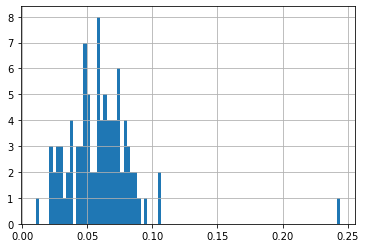

In [154]:
otchet['cm3_perc'].hist(bins=90)

<AxesSubplot:ylabel='Frequency'>

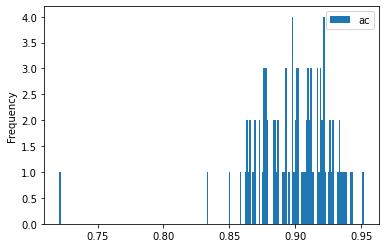

In [149]:
otchet[['reg','ac']].plot.hist(x='reg', y='ac', bins = 194) #bar(x='reg', y='ac')

## Важность признаков

In [195]:
valid_pool = Pool(data=X_valid, label=y_valid, cat_features = cat) 

P1 = model.get_feature_importance(valid_pool, type='FeatureImportance', prettified=True,
    thread_count=-1,
    verbose=True)

P1['Feature'] = list(fetures_map[x] for x in list(P1['Feature Id']))

Used dataset leave statistics for fstr calculation


,Feature Id,Importances
0,f1r13r1,20.804738
1,f1r9_1g1,12.554768
2,f1r9,5.671052
3,f1r19,5.250562
4,t11-5,4.764814
5,f1r40,4.421873
6,f1r19_1,4.374639
7,region,3.137378
8,f1r33g2,3.008239
9,s_ch_max_p,2.421225


In [199]:
P1[['Feature', 'Feature Id', 'Importances']].head(8)


,Feature,Feature Id,Importances
0,статья+знак+часть Квалификация преступления по...,f1r13r1,20.804738
1,Выявлено по оперативным данным 1 (р.9),f1r9_1g1,12.554768
2,Кем выявлено (р.9),f1r9,5.671052
3,Место совершения преступления (р.19),f1r19,5.250562
4,Период от даты куп до возб. у.д.,t11-5,4.764814
5,Округ служба (р.40),f1r40,4.421873
6,Место совершения преступления по ОКАТО (р.19),f1r19_1,4.374639
7,Код региона,region,3.137378


In [200]:
P1[['Feature', 'Feature Id', 'Importances']].to_excel('Влияние признаков на валидационном датасете.xls')

<ipython-input-200-0a3cb50544d6>:1: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  P1[['Feature', 'Feature Id', 'Importances']].to_excel('Влияние признаков на валидационном датасете.xls')


## НИЖЕ РАЗЛИЧНЫЕ АРТЕФАКТЫ можете посмотреть одним глазком графики раскрываемости преступлений

In [239]:
act_20.merge(tst21[['ID', 'raskr']], how='inner', left_on='ID', right_on='ID')

,region,f1r1r1,f1r1r2,f1r2,f1r3r1,f1r3r2,f1r3r3,f1r3_3,f1r4,f1r5r2,...,f1r25_2r2BIN,st,f1r13r2_max_c,f1r13r2_s_c,s_ch_p,s_ch_max_p,pp,p,ID,raskr_y
0,1101,1,43,1,1,2019,453,11901010008000453,1,2019-09-30,...,0,260,999,999,260003999,260003999,0.514634,1,119010100080004531,1
1,1101,1,43,1,1,2019,556,11901010008000556,1,2019-11-15,...,0,112,2,2,1120022,1120022,0.941299,1,119010100080005561,1
2,1101,1,55,1,1,2019,282,11901010009000282,1,2019-06-30,...,0,158,999,999,158001999,158001999,0.847959,1,119010100090002821,1
3,1101,1,60,1,1,2019,1918,11901010038001918,1,2019-11-26,...,0,159,999,999,159011999,159011999,0.815540,1,119010100380019181,1
4,1101,1,60,1,1,2019,1988,11901010038001988,1,2019-11-11,...,0,159,999,999,159031999,159031999,0.900537,1,119010100380019881,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262176,6204,1,13,1,1,2020,1000260,12001009311000260,1,2020-11-13,...,0,158,999,999,158001999,158001999,0.108085,0,120010093110002601,1
262177,6204,1,27,1,1,2020,1000029,12001009314000029,1,2020-08-17,...,0,161,999,999,161001999,161001999,0.880630,1,120010093140000291,1
262178,6204,1,27,1,1,2020,1000033,12001009314000033,1,2020-09-11,...,0,228,999,999,228001999,228001999,0.990836,1,120010093140000331,1
262179,6204,4,34,1,1,2020,4000016,12004009303000016,1,2020-01-28,...,0,226,999,999,226011999,226011999,0.728143,1,120040093030000161,1


In [103]:




# фактически НЕраскрыто спрогнозировано как НЕраскрытое (Кол-во верно предсказанных нераскрытых)
# фактически НЕраскрыто спрогнозировано как раскрытое  (перспективные для раскрытия)
# фактически раскрыто спрогнозировано как НЕраскрытое  (кол-во спрогнозированных как нераскрытых Ошибочно )
# фактически раскрыто спрогнозировано как раскрытое     (Кол-во верно предсказанных раскрытых)

print(confusion_matrix(tst[y].loc[tst['region'] == i], tst['p'].loc[tst['region'] == i]) )

[[25343  1623]
 [ 2691 22260]]


In [28]:
model.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'Logloss',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'],
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'fold_permutation_block': 0,
 'leaf_estimation_method': 'Gradient',
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'ctr_leaf_count_limit': 18446744073709551615,
 'bayesian_matrix_reg': 0.10000000149011612,
 'one_hot_max_size': 256,
 'l2_leaf_reg': 6,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': False,
 'max_ctr_complexity': 6,
 'model_size_reg': 0.5,
 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrB

In [29]:
print('accuracy 2020', accuracy_score(tst[y], model.predict(tst[cols2])) )

accuracy 2020 0.919825265851829


In [30]:
print('f1 2020',  f1_score(tst[y], model.predict(tst[cols2])) )

f1 2020 0.9008999181892555


In [31]:
print('roc_auc 2020', roc_auc_score(tst[y], model.predict_proba(tst[cols2])[:,1:]))

roc_auc 2020 0.9722620891095635


In [32]:
print (confusion_matrix(tst21[y], model.predict(tst21[cols2])) )

# истинно положительные ложно отрицательный
# ложно- положительный  результат истинно отрицательные

[[   0    0]
 [ 788 1408]]


In [33]:
print(confusion_matrix(tst[y], model.predict(tst[cols2])) )

[[62935  3351]
 [ 5734 41295]]


In [34]:
tst.region.value_counts()

1150    52204
1105    31993
1120    29118
Name: region, dtype: int64

In [35]:
for dff in [tst, tst21]:
    #print(str(dff))
    for i in [1150, 1105, 1120]:
        print(i, '\n', confusion_matrix(dff[y].loc[dff['region'] == i], model.predict(dff[cols2].loc[dff['region'] == i])) )

1150 
 [[31773  1226]
 [ 2771 16434]]
1105 
 [[15072  1462]
 [ 1157 14302]]
1120 
 [[16090   663]
 [ 1806 10559]]
1150 
 [[  0   0]
 [368 545]]
1105 
 [[  0   0]
 [156 529]]
1120 
 [[  0   0]
 [264 334]]


In [135]:
#нераскрытые ппл по итогам 2020 16753
tst[(tst['region'] == 1150) & (tst['raskr'] == 0)].shape[0]

32999

In [136]:
#ППЛ 2020 спрогнозированные как раскр
tst[(tst['region'] == 1150) & (tst['raskr'] == 0) & (tst['M1'] >= .5)].shape[0]

1226

In [138]:
tst['M1'] = model.predict_proba(tst[cols2])[:,1:]

ls = []
for t in list(tst['s_ch_p']):
    ls.append(str(t)[:7])

tst['s_ch'] = ls

In [139]:

tst[['region', 'f1r3_3', 'f1r4', 's_ch', 'M1', 'raskr']][(tst['raskr'] == 0) & (tst['M1'] >=.5)].to_csv('report_1105_1120_1150_model1.csv', index =False)

In [140]:
tst[['region', 'f1r3_3', 'f1r4', 's_ch', 'M1', 'raskr']]

,region,f1r3_3,f1r4,s_ch,M1,raskr
0,1105,11901050002000596,1,2640109,0.915780,1
1,1105,11901050002000603,1,2280019,0.922153,1
2,1105,11901050002000611,1,1600039,0.644070,1
3,1105,11901050002000613,1,1190019,0.872159,1
4,1105,11901050002000630,1,2280019,0.858662,1
...,...,...,...,...,...,...
113310,1150,11902500039000092,1,2160019,0.973370,1
113311,1150,12001500048000001,1,1710021,0.968472,1
113312,1150,12001500048000002,1,1580019,0.697773,1
113313,1150,11901500048000043,1,1590049,0.583886,0


In [37]:
model2 = CatBoostClassifier(
    iterations = 50, #10k
    #save_snapshot=True, #сохранять прогресс обучения
    #snapshot_file='full110cbm.bkp',
    #snapshot_interval=60, #интервал сохранения прогресса обучения в сек.
    
    #learning_rate = 0.015, #0.1,   0.000001,  0.029999999329447743 '
    random_seed = 42,
    l2_leaf_reg = 6,
    max_ctr_complexity = 6,#2
    depth = 8, #4
    grow_policy = 'SymmetricTree', #SymmetricTree Depthwise Lossguide
    loss_function = 'Logloss',
    leaf_estimation_method = 'Gradient', #'Newton', #Gradient , Exact
    one_hot_max_size = 256,
    #used_ram_limit = '300GB',
    use_best_model = True,
    min_data_in_leaf = 4,
    custom_loss=['AUC', 'Accuracy', 'F1']
      
    #custom_loss=['AUC', 'Accuracy','BalancedAccuracy', 'F1','TotalF1'], #,'MAE','RMSE','R2', 'CtrFactor',  'Kappa', 'MultiRMSE', 'YetiRank','MCC' , 'CrossEntropy', 'Precision' , 'Recall',  'BalancedErrorRate', 'NormalizedGini'
    #logging_level = 'Info' #Silent Verbose Info Debug
)
model2.fit(
    # df[cols2], 
    # df[y],
    #train_pool,
    dz[cols2],  dz[y],
    cat_features = cat,
    eval_set = (tst21[cols2],  tst21[y])
    
        #eval_set=valid_pool,
    #eval_set=(ner[cols2], ner[y]) #eval_set=(tst[cols], tst[y])
    
    #verbose = True,
    #plot = True
    #init_model='3chunk.cbm'
)


#model.save_model('/V11/prognoz/dbmodels/full100/full110.cbm')
print('roc_auc train', roc_auc_score(y_train, model2.predict_proba(X_train)[:,1:])) 

print('accuracy valid', accuracy_score(y_valid, model2.predict(X_valid)) )
print('roc_auc valid', roc_auc_score(y_valid, model2.predict_proba(X_valid)[:,1:])) 

print('accuracy FINAL', accuracy_score(tst21[y], model2.predict(tst21[cols2])) )

0:	learn: 0.6718714	test: 0.6880453	best: 0.6880453 (0)	total: 2.47s	remaining: 2m 1s
1:	learn: 0.6520356	test: 0.6829089	best: 0.6829089 (1)	total: 3.34s	remaining: 1m 20s
2:	learn: 0.6337314	test: 0.6790807	best: 0.6790807 (2)	total: 4.96s	remaining: 1m 17s
3:	learn: 0.6168478	test: 0.6758087	best: 0.6758087 (3)	total: 5.63s	remaining: 1m 4s
4:	learn: 0.6013513	test: 0.6716858	best: 0.6716858 (4)	total: 6.55s	remaining: 59s
5:	learn: 0.5866058	test: 0.6669684	best: 0.6669684 (5)	total: 7.2s	remaining: 52.8s
6:	learn: 0.5728087	test: 0.6657011	best: 0.6657011 (6)	total: 7.71s	remaining: 47.4s
7:	learn: 0.5604049	test: 0.6653025	best: 0.6653025 (7)	total: 8.53s	remaining: 44.8s
8:	learn: 0.5484385	test: 0.6624955	best: 0.6624955 (8)	total: 9.91s	remaining: 45.2s
9:	learn: 0.5373034	test: 0.6612402	best: 0.6612402 (9)	total: 11.7s	remaining: 46.6s
10:	learn: 0.5271367	test: 0.6619374	best: 0.6612402 (9)	total: 13.1s	remaining: 46.3s
11:	learn: 0.5177376	test: 0.6618540	best: 0.6612402 (

In [38]:
model.save_model('model_2.cbm')

In [39]:
model2.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'Logloss',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'],
 'iterations': 50,
 'sampling_frequency': 'PerTree',
 'fold_permutation_block': 0,
 'leaf_estimation_method': 'Gradient',
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'ctr_leaf_count_limit': 18446744073709551615,
 'bayesian_matrix_reg': 0.10000000149011612,
 'one_hot_max_size': 256,
 'l2_leaf_reg': 6,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': False,
 'max_ctr_complexity': 6,
 'model_size_reg': 0.5,
 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBor

In [40]:
for dff in [tst, tst21]:
    #print(str(dff))
    for i in [1150, 1105, 1120]:
        print(i, '\n', confusion_matrix(dff[y].loc[dff['region'] == i], model2.predict(dff[cols2].loc[dff['region'] == i])) )

1150 
 [[30288  2711]
 [ 3966 15239]]
1105 
 [[14443  2091]
 [ 3447 12012]]
1120 
 [[15123  1630]
 [ 3012  9353]]
1150 
 [[  0   0]
 [393 520]]
1105 
 [[  0   0]
 [253 432]]
1120 
 [[  0   0]
 [246 352]]


# VERY OLD artefact

In [22]:
X_train2, X_valid2, y_train2, y_valid2 = train_test_split(trn[cols2], trn[y], test_size=0.2, random_state=40) #cols2

model3 = CatBoostClassifier(
    iterations = 100, #10k
    ##10k
    #save_snapshot=True, #сохранять прогресс обучения
    #snapshot_file='full110cbm.bkp',
    #snapshot_interval=60, #интервал сохранения прогресса обучения в сек.
    learning_rate = 0.015, #0.1, 0.000001
    random_seed = 42,
    l2_leaf_reg = 6,
    max_ctr_complexity = 6,#2
    depth = 8, #4
    grow_policy = 'SymmetricTree', #SymmetricTree Depthwise Lossguide
    loss_function = 'Logloss',
    leaf_estimation_method = 'Gradient', #'Newton', #Gradient , Exact
    one_hot_max_size = 256,
    #used_ram_limit = '300GB',
    use_best_model = True,
    min_data_in_leaf = 4
      
    #custom_loss=['AUC', 'Accuracy','BalancedAccuracy', 'F1','TotalF1'], #,'MAE','RMSE','R2', 'CtrFactor',  'Kappa', 'MultiRMSE', 'YetiRank','MCC' , 'CrossEntropy', 'Precision' , 'Recall',  'BalancedErrorRate', 'NormalizedGini'
    #logging_level = 'Info' #Silent Verbose Info Debug
)
model3.fit(
    # trn[cols2], 
    # trn[y],
    #train_pool,
    X_train2,  y_train2,
    cat_features = cat,
    #eval_set=(tst[cols2], tst[y])
    eval_set = (X_valid2, y_valid2)
    #custom_loss='Accuracy',
        #eval_set=valid_pool,
    #eval_set=(ner[cols2], ner[y]) 
    #verbose = True,
    #plot = True
    #init_model='3chunk.cbm'
)


#model.save_model('/V11/prognoz/dbmodels/full100/full110.cbm')
print('accuracy valid',accuracy_score(y_valid2, model3.predict(X_valid2)))


print('accuracy tst', accuracy_score(tst[y], model3.predict(tst[cols2])))


0:	learn: 0.6729246	test: 0.6729004	best: 0.6729004 (0)	total: 14.5s	remaining: 23m 56s
1:	learn: 0.6533864	test: 0.6533235	best: 0.6533235 (1)	total: 28.2s	remaining: 23m 2s
2:	learn: 0.6346404	test: 0.6345012	best: 0.6345012 (2)	total: 39.3s	remaining: 21m 9s
3:	learn: 0.6167163	test: 0.6165488	best: 0.6165488 (3)	total: 50.9s	remaining: 20m 20s
4:	learn: 0.5994877	test: 0.5992893	best: 0.5992893 (4)	total: 1m 3s	remaining: 19m 58s
5:	learn: 0.5829871	test: 0.5827640	best: 0.5827640 (5)	total: 1m 14s	remaining: 19m 29s
6:	learn: 0.5671033	test: 0.5668278	best: 0.5668278 (6)	total: 1m 25s	remaining: 18m 56s
7:	learn: 0.5516673	test: 0.5513524	best: 0.5513524 (7)	total: 1m 38s	remaining: 18m 47s
8:	learn: 0.5368977	test: 0.5365571	best: 0.5365571 (8)	total: 1m 50s	remaining: 18m 35s
9:	learn: 0.5227256	test: 0.5223464	best: 0.5223464 (9)	total: 2m 1s	remaining: 18m 16s
10:	learn: 0.5091567	test: 0.5087575	best: 0.5087575 (10)	total: 2m 14s	remaining: 18m 4s
11:	learn: 0.4961040	test: 0

In [23]:
tst['pp3'] = model3.predict_proba(tst[cols2])[:,1:]

In [25]:
print(roc_auc_score(y_valid2, model3.predict_proba(X_valid2)[:,1:]))

0.8657139658598604


In [47]:
#os.mkdir('/V11/prognoz/dbmodels/pplmodel')
model3.save_model('/V11/prognoz/dbmodels/pplmodel/pplmodel3.cbm')

<AxesSubplot:ylabel='Frequency'>

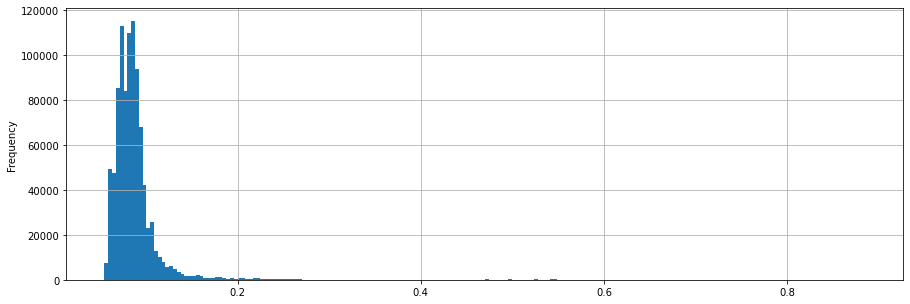

In [125]:
tst[['pp3']].loc[(tst['pp3']>0) ].sort_values(by=['pp3']).plot.hist(xlabel= 'predict_proba', ylabel='Количество преступлений', bins=200, figsize=(15,5), grid=True, legend=False)

<AxesSubplot:ylabel='Frequency'>

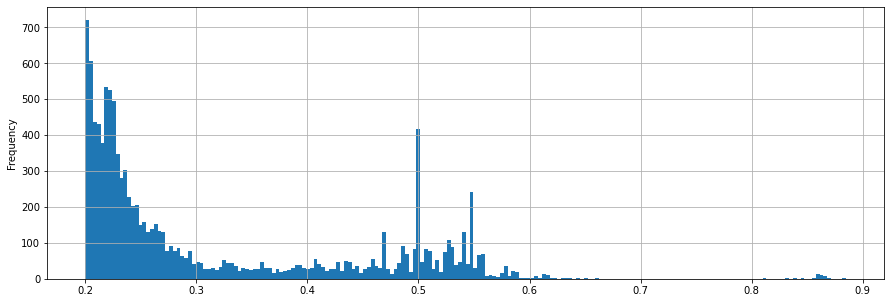

In [127]:
tst[['pp3']].loc[(tst['pp3']>.2) ].sort_values(by=['pp3']).plot.hist(xlabel= 'predict_proba', ylabel='Количество преступлений', bins=200, figsize=(15,5), grid=True, legend=False)


<AxesSubplot:ylabel='Frequency'>

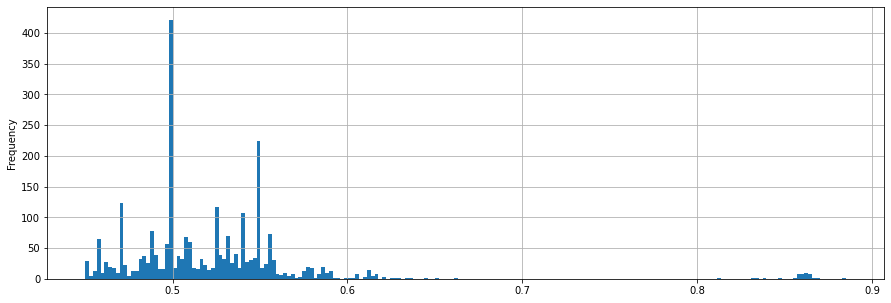

In [129]:
tst[['pp3']].loc[(tst['pp3']>.45) ].sort_values(by=['pp3']).plot.hist(bins=200, figsize=(15,5), grid=True, legend=False)

<AxesSubplot:ylabel='Frequency'>

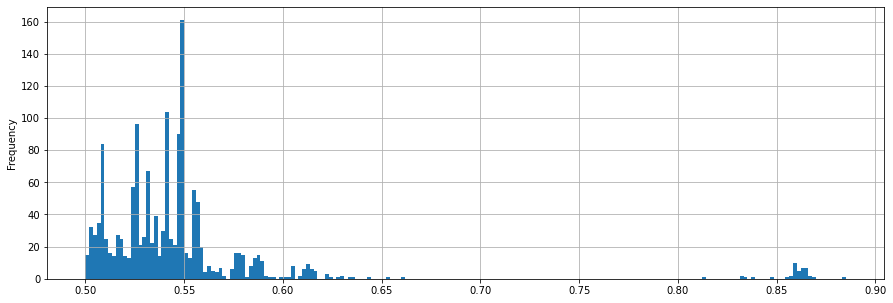

In [130]:
tst[['pp3']].loc[(tst['pp3']>.5) ].sort_values(by=['pp3']).plot.hist(bins=200, figsize=(15,5), grid=True, legend=False)

In [135]:

P1 = model3.get_feature_importance(tst_pool, type='FeatureImportance', prettified=True,
    thread_count=-1,
    verbose=True)

Used dataset leave statistics for fstr calculation


In [138]:
P1.head(15)

,Feature Id,Importances
0,f1r3r2,18.352055
1,region,18.204365
2,s_ch_min_p,14.486289
3,s_ch_max_p,8.217350
4,f1r19_1,8.144794
5,f1r11r2-month,6.775397
6,f1r13r1,5.557526
7,s_ch_p,5.129518
8,f1r1r2,3.382468
9,f1r9_1g1,2.893086


In [147]:
fetures_map['f1r40']

'Округ служба (р.40)'

## ДЛЯ 2021 года

In [158]:
tst21['pp3'] = model3.predict_proba(tst21[cols2])[:,1:]

In [161]:
tst21['p3']=model3.predict(tst21[cols2])

In [159]:
accuracy_score(tst21['raskr'],model3.predict(tst21[cols2]))

0.4700996768746802

In [160]:
tst21.loc[(tst21['raskr']==0) & (tst21['pp3']>.5)]

,region,f1r1r1,f1r1r2,f1r2,f1r3r1,f1r3r2,f1r3r3,f1r3_3,f1r4,f1r8,...,f1r25_2r2,f1r25_2r2BIN,f1r13r2_max_c,f1r13r2_min_c,f1r13r2_s_c,st,s_ch_p,s_ch_max_p,s_ch_min_p,pp3
1191,1101,1,36,1,1,2020,492,12001010028000492,1,-9999,...,0,0,999,999,999,264,264010999,264010999,264010999,0.549680
1244,1101,1,36,1,1,2020,565,12001010028000565,1,-9999,...,0,0,999,999,999,264,264010999,264010999,264010999,0.543007
2810,1101,1,60,1,1,2020,1518,12001010038001518,1,-9999,...,0,0,999,999,999,158,158010999,158010999,158010999,0.502924
9489,1101,1,36,1,1,2021,37,12101010028000037,1,-9999,...,0,0,999,999,999,264,264010999,264010999,264010999,0.549232
9490,1101,1,36,1,1,2021,38,12101010028000038,1,-9999,...,0,0,999,999,999,264,264010999,264010999,264010999,0.549232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899415,6115,2,6710,1,1,2021,35,12102350021000035,1,-9999,...,0,0,999,999,999,319,319000999,319000999,319000999,0.520672
899908,6117,2,74,1,1,2020,21390,12002009803021390,1,-9999,...,0,0,999,999,999,319,319000999,319000999,319000999,0.540622
903609,6118,2,1400,1,1,2021,9,12102009603000009,1,-9999,...,0,0,999,999,999,319,319000999,319000999,319000999,0.520623
905465,6119,2,6000,1,1,2020,17,12002008109000017,1,-9999,...,0,0,999,999,999,319,319000999,319000999,319000999,0.528594


In [162]:
tst21nul=tst21.loc[(tst21['raskr']==0)]

In [163]:
accuracy_score(tst21nul['raskr'], tst21nul['p3'])

0.9976230285813124

In [168]:
tst21nul[['pp3']].loc[(tst21nul['pp3']>.45)& (tst21nul['region']==1120)]

,pp3
196836,0.508088
197272,0.498140
197703,0.507799
199040,0.508088
200905,0.490782
201470,0.531786
201981,0.480856
203688,0.472238
204546,0.497924
204652,0.497924


<AxesSubplot:ylabel='Frequency'>

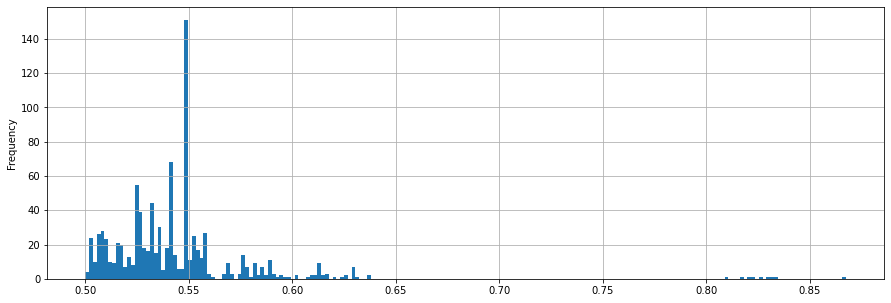

In [245]:
tst21nul[['pp3']].loc[(tst21nul['pp3']>.5) ].sort_values(by=['pp3']).plot.hist(bins=200, figsize=(15,5), grid=True, legend=False)

<AxesSubplot:ylabel='Frequency'>

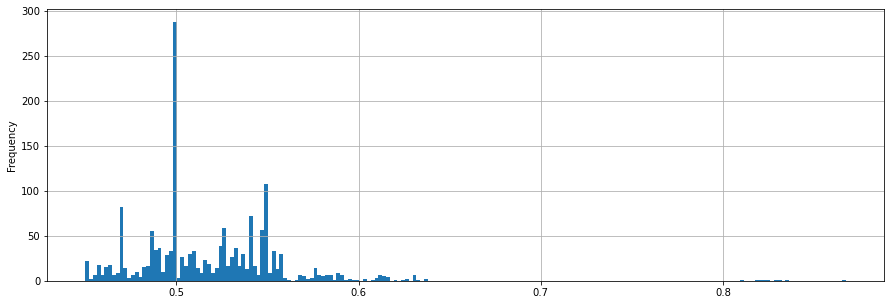

In [164]:
tst21nul[['pp3']].loc[(tst21nul['pp3']>.45) ].sort_values(by=['pp3']).plot.hist(bins=200, figsize=(15,5), grid=True, legend=False)

In [169]:
tst21nul[['region', 'f1r3r2', 'f1r3r3', 'f1r3_3', 'f1r4' ,'f1r13r1', 'pp3']].loc[(tst21nul['pp3']>.45) ].to_csv('/V11/prognoz/dbmodels/pplmodel/tstPP_upper45percent(files_20210601_all).csv')

In [170]:
tst21nul['raskr'].value_counts()

0    381578
Name: raskr, dtype: int64

In [171]:
tst21nul[['region', 'f1r3r2', 'f1r3r3', 'f1r3_3', 'f1r4' ,'f1r13r1', 'pp3']].loc[(tst21nul['pp3']>.45) ].shape

(1644, 7)

In [172]:
tst[['region', 'f1r3r2', 'f1r3r3', 'f1r3_3', 'f1r4' ,'f1r13r1', 'pp3']].loc[(tst['pp3']>.45) ].shape

(2573, 7)

In [173]:
predPPL = pd.concat([tst[['region', 'f1r3r2', 'f1r3r3', 'f1r3_3', 'f1r4' ,'f1r13r1', 'pp3']].loc[(tst['pp3']>.45) ], 
    tst21nul[['region', 'f1r3r2', 'f1r3r3', 'f1r3_3', 'f1r4' ,'f1r13r1', 'pp3']].loc[(tst21nul['pp3']>.45) ]], ignore_index=True) #tst21,trn20

In [176]:
predPPL.to_csv('/V11/prognoz/dbmodels/pplmodel/ALLPPL_upper45percent.csv')

In [215]:
zal = ['f1r21',
    'f1r8',
 'f1r9',
 'f1r9_1g1',
 'f1r9_1g2',
 'f1r10',
 'f1r10_1',
 'f1r10_2',
 'f1r10_3',
 'f1r11r1',
 'f1r12r2',
 'f1r13r1',
 'f1r15',
 'f1r16',
 'f1r17',
 'f1r18',
 'f1r19',
 'f1r19_1',
 'f1r20'
 ]

In [241]:
spis=list(fetures_map[x] for x in zal)
spis

['Преступление совершено (место) (р.21)',
 'Предотвращено (р.8)',
 'Кем выявлено (р.9)',
 'Выявлено по оперативным данным  1 (р.9)',
 'Выявлено по оперативным данным 2 (р.9)',
 'Кем возбуждено уголовное дело (р.10)',
 'У.д. возбуждено при отмене постановления об отказе в возбуждении у.д. (р.10)',
 'Преступление ранее было укрыто от учета (р.10)',
 'Факт укрытия преступления допущен (р.10)',
 'Возб.дело, пост.об отказе (р.11)',
 'Время (час) совершения преступления (р.12)',
 'статья+знак+часть Квалификация преступления по УК РФ (р.13)',
 'Тяжесть (р.15)',
 'Приготовление/покушение (р.16)',
 'Ущерб (крупный, особо крупный, …) (р.17)',
 'Направленность (р.18)',
 'Место совершения преступления (р.19)',
 'Место совершения преступления по ОКАТО (р.19)',
 'Форма хозяйствующего субъекта (р.20)']

In [132]:
for zxc in [1145, 1146, 1151, 6101, 6120, 6204]:
    print(trn['raskr'].loc[ (trn['region']==zxc )].value_counts())

0    785365
Name: raskr, dtype: int64
0    269414
Name: raskr, dtype: int64
0    1263
1      57
Name: raskr, dtype: int64
0    1867
1     462
Name: raskr, dtype: int64
0    9228
1     167
Name: raskr, dtype: int64
0    2698
1     163
Name: raskr, dtype: int64


In [67]:
for zxc in [1145,1146,1151,1177,1180,1184,1195,6101,6120,6204]:
    print(trn['raskr'].loc[ (trn['region']==zxc )].value_counts())

0    785365
Name: raskr, dtype: int64
0    269414
Name: raskr, dtype: int64
0    1263
1      57
Name: raskr, dtype: int64
0    1144
1     170
Name: raskr, dtype: int64
0    162459
1       652
Name: raskr, dtype: int64
0    8018
1     442
Name: raskr, dtype: int64
0    26797
1     1195
Name: raskr, dtype: int64
0    1867
1     462
Name: raskr, dtype: int64
0    9228
1     167
Name: raskr, dtype: int64
0    2698
1     163
Name: raskr, dtype: int64


In [56]:
model = CatBoostClassifier(
    iterations = 5000, #10k
    #save_snapshot=True, #сохранять прогресс обучения
    #snapshot_file='full110cbm.bkp',
    #snapshot_interval=60, #интервал сохранения прогресса обучения в сек.
    learning_rate = 0.015, #0.1,   0.000001
    random_seed = 42,
    l2_leaf_reg = 6,
    max_ctr_complexity = 6,#2
    depth = 8, #4
    grow_policy = 'SymmetricTree', #SymmetricTree Depthwise Lossguide
    loss_function = 'Logloss',
    leaf_estimation_method = 'Gradient', #'Newton', #Gradient , Exact
    one_hot_max_size = 256,
    #used_ram_limit = '300GB',
    use_best_model = True,
    min_data_in_leaf = 4
      
    #custom_loss=['AUC', 'Accuracy','BalancedAccuracy', 'F1','TotalF1'], #,'MAE','RMSE','R2', 'CtrFactor',  'Kappa', 'MultiRMSE', 'YetiRank','MCC' , 'CrossEntropy', 'Precision' , 'Recall',  'BalancedErrorRate', 'NormalizedGini'
    #logging_level = 'Info' #Silent Verbose Info Debug
)
model.fit(
    # df[cols2], 
    # df[y],
    #train_pool,
    X_train,  y_train,
    cat_features = cat,
    eval_set = (X_valid, y_valid)
    #custom_loss='Accuracy',
        #eval_set=valid_pool,
    #eval_set=(ner[cols2], ner[y]) #eval_set=(tst[cols], tst[y])
    
    #verbose = True,
    #plot = True
    #init_model='3chunk.cbm'
)


#model.save_model('/V11/prognoz/dbmodels/full100/full110.cbm')

accuracy_score(y_valid, model.predict(X_valid))

05108 (4785)	total: 4m 16s	remaining: 11.5s
4786:	learn: 0.0953647	test: 0.1905071	best: 0.1905071 (4786)	total: 4m 16s	remaining: 11.4s
4787:	learn: 0.0953641	test: 0.1905086	best: 0.1905071 (4786)	total: 4m 16s	remaining: 11.3s
4788:	learn: 0.0953600	test: 0.1905091	best: 0.1905071 (4786)	total: 4m 16s	remaining: 11.3s
4789:	learn: 0.0953330	test: 0.1905035	best: 0.1905035 (4789)	total: 4m 16s	remaining: 11.2s
4790:	learn: 0.0953189	test: 0.1904904	best: 0.1904904 (4790)	total: 4m 16s	remaining: 11.2s
4791:	learn: 0.0953056	test: 0.1904937	best: 0.1904904 (4790)	total: 4m 16s	remaining: 11.1s
4792:	learn: 0.0952932	test: 0.1904898	best: 0.1904898 (4792)	total: 4m 16s	remaining: 11.1s
4793:	learn: 0.0952709	test: 0.1904744	best: 0.1904744 (4793)	total: 4m 16s	remaining: 11s
4794:	learn: 0.0952360	test: 0.1904769	best: 0.1904744 (4793)	total: 4m 16s	remaining: 11s
4795:	learn: 0.0952289	test: 0.1904777	best: 0.1904744 (4793)	total: 4m 16s	remaining: 10.9s
4796:	learn: 0.0952050	test: 0

0.928113767776215

In [57]:
accuracy_score(tst21[y], model.predict(tst21[cols2]))

0.8995002437835202

In [59]:
ner21 = tst21.loc[tst21['raskr']==0]

In [60]:
accuracy_score(ner21[y], model.predict(ner21[cols2]))

0.8637890284861302

In [79]:
model2 = CatBoostClassifier(
    iterations = 100, #10k
    #save_snapshot=True, #сохранять прогресс обучения
    #snapshot_file='full110cbm.bkp',
    #snapshot_interval=60, #интервал сохранения прогресса обучения в сек.
    learning_rate = 0.6, #0.1,   0.000001
    random_seed = 42,
    l2_leaf_reg = 6,
    max_ctr_complexity = 6,#2
    depth = 8, #4
    grow_policy = 'SymmetricTree', #SymmetricTree Depthwise Lossguide
    loss_function = 'Logloss',
    leaf_estimation_method = 'Gradient', #'Newton', #Gradient , Exact
    one_hot_max_size = 256,
    #used_ram_limit = '300GB',
    use_best_model = True,
    min_data_in_leaf = 4
      
    #custom_loss=['AUC', 'Accuracy','BalancedAccuracy', 'F1','TotalF1'], #,'MAE','RMSE','R2', 'CtrFactor',  'Kappa', 'MultiRMSE', 'YetiRank','MCC' , 'CrossEntropy', 'Precision' , 'Recall',  'BalancedErrorRate', 'NormalizedGini'
    #logging_level = 'Info' #Silent Verbose Info Debug
)
model2.fit(
    # df[cols2], 
    # df[y],
    #train_pool,
    X_train,  y_train,
    cat_features = cat,
    eval_set = (X_valid, y_valid)
    #eval_set =(ner21[cols2],ner21[y])
    #custom_loss='Accuracy',
        #eval_set=valid_pool,
    #eval_set=(ner[cols2], ner[y]) #eval_set=(tst[cols], tst[y])
    
    #verbose = True,
    #plot = True
    #init_model='3chunk.cbm'
)


#model.save_model('/V11/prognoz/dbmodels/full100/full110.cbm')

accuracy_score(ner21[y], model2.predict(ner21[cols2]))

0:	learn: 0.4812037	test: 0.4783035	best: 0.4783035 (0)	total: 365ms	remaining: 36.2s
1:	learn: 0.4320253	test: 0.4290536	best: 0.4290536 (1)	total: 738ms	remaining: 36.2s
2:	learn: 0.4085184	test: 0.4061463	best: 0.4061463 (2)	total: 1.03s	remaining: 33.5s
3:	learn: 0.3980603	test: 0.3959126	best: 0.3959126 (3)	total: 1.39s	remaining: 33.3s
4:	learn: 0.3897061	test: 0.3883634	best: 0.3883634 (4)	total: 1.63s	remaining: 31s
5:	learn: 0.3823373	test: 0.3817422	best: 0.3817422 (5)	total: 1.97s	remaining: 30.8s
6:	learn: 0.3772153	test: 0.3768560	best: 0.3768560 (6)	total: 2.27s	remaining: 30.1s
7:	learn: 0.3744302	test: 0.3743980	best: 0.3743980 (7)	total: 2.55s	remaining: 29.3s
8:	learn: 0.3718938	test: 0.3722000	best: 0.3722000 (8)	total: 2.86s	remaining: 28.9s
9:	learn: 0.3691798	test: 0.3696110	best: 0.3696110 (9)	total: 3.12s	remaining: 28.1s
10:	learn: 0.3669744	test: 0.3676179	best: 0.3676179 (10)	total: 3.4s	remaining: 27.5s
11:	learn: 0.3649837	test: 0.3658816	best: 0.3658816 (1

0.7584276651324792

In [13]:
model3=CatBoostClassifier()
model3.load_model('/V11/prognoz/dbmodels/full110/full110.cbm')

In [14]:
trn[cols2].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8039 entries, 0 to 8038
Columns: 130 entries, f1r9_1g1 to f1r35g1
dtypes: int16(91), int32(11), int64(1), int8(27)
memory usage: 2.1 MB


In [19]:
for df in [trn]:
    for i in trn[cols2].columns:
        df[i]= df[i].astype(ner_slv[i])

In [ ]:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 381596 entries, 0 to 381595
Columns: 130 entries, f1r1r2 to f1r5r2-month
dtypes: int16(90), int32(15), int64(2), int8(23)
memory usage: 104.4 MB

In [20]:
trn[cols2].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8039 entries, 0 to 8038
Columns: 130 entries, f1r9_1g1 to f1r35g1
dtypes: int16(90), int32(15), int64(2), int8(23)
memory usage: 2.2 MB


In [15]:
ner_slv = {'f1r1r2': 'int32',
'f1r27g4': 'int16',
'f1r27g3': 'int16',
'f1r9_1g2': 'int16',
'f1r22': 'int32',
's_ch_p': 'int32',
'f1r23_1g1': 'int16',
'f1r2': 'int8',
'f1r1r1': 'int8',
'f1r19': 'int32',
'f1r24g1': 'int16',
'f1r30_4': 'int16',
'f1r4': 'int16',
'f1r27g5': 'int16',
'f1r28g4': 'int16',
'f1r15': 'int8',
'f1r27g6': 'int16',
'f1r37g1': 'int16',
'f1r30_7': 'int16',
'f1r11r2-month': 'int8',
'f1r11r2-weekofyear': 'int8',
'f1r16': 'int16',
'f1r25_1r1g8': 'int16',
'f1r12r1-dayofweek': 'int8',
'f1r12r1-month': 'int8',
'f1r13r2_s_c': 'int16',
'f1r23_1g2': 'int16',
'f1r21_1': 'int16',
'f1r11r1': 'int16',
'f1r33g5': 'int16',
'f1r36g1': 'int16',
'f1r25_1r1g1': 'int16',
'f1r17': 'int16',
'f1r25_1r1g2': 'int16',
'f1r12r1-quarter': 'int8',
'f1r29_1g4': 'int16',
'f1r36g2': 'int16',
'f1r25r2': 'int64',
's_ch_max_p': 'int32',
'f1r33g1': 'int16',
'f1r23_1g3': 'int16',
'f1r26g5': 'int16',
'f1r24g3': 'int16',
'f1r35g2': 'int32',
'f1r12r1-weekofyear': 'int8',
'f1r30_10': 'int16',
'f1r30_1': 'int16',
'f1r25_1r1g9': 'int16',
'f1r32r2': 'int16',
'f1r12r2': 'int8',
'f1r28g2': 'int16',
'f1r25_2r2': 'int32',
'f1r23g1': 'int32',
't11-12': 'int32',
'f1r5r2-weekofyear': 'int8',
'f1r26g2': 'int16',
't5-12': 'int32',
'f1r25_1r1g3': 'int16',
'f1r12r1-day': 'int8',
'f1r28g3': 'int16',
'f1r34g1': 'int16',
'f1r30_9': 'int16',
'f1r31': 'int16',
'f1r30_2': 'int16',
'f1r26g4': 'int16',
'st': 'int16',
'f1r3r1': 'int16',
'f1r13r2_max_c': 'int16',
'f1r29_1g1': 'int16',
'f1r11r2-quarter': 'int8',
'f1r25_1r1g4': 'int16',
'f1r28g1': 'int16',
'f1r12r1-dayofyear': 'int16',
'f1r35g1': 'int32',
'f1r11r2-dayofweek': 'int8',
'f1r10_2': 'int16',
'f1r21': 'int16',
'f1r5r2-dayofyear': 'int16',
'f1r33g2': 'int16',
'f1r25r2BIN': 'int8',
'f1r27g1': 'int16',
'f1r18': 'int8',
'f1r23g3': 'int16',
'f1r3r3': 'int32',
'f1r40': 'int16',
'f1r29': 'int16',
'f1r23g2': 'int16',
'f1r28g5': 'int16',
'f1r25_2r2BIN': 'int8',
'f1r5r2-quarter': 'int8',
't11-5': 'int16',
'f1r3r2': 'int16',
'f1r26g1': 'int16',
'f1r25_2r1g1': 'int16',
'f1r5r2-day': 'int8',
'f1r5r2-dayofweek': 'int8',
'f1r19_1': 'int64',
'f1r11r2-day': 'int8',
'f1r10_1': 'int16',
'region': 'int16',
'f1r10_3': 'int16',
'f1r20': 'int16',
'f1r25_1r1g7': 'int16',
'f1r29_1g2': 'int16',
'f1r25_2r1g2': 'int16',
'f1r25_1r1g5': 'int16',
'f1r34g2': 'int16',
'f1r27g2': 'int16',
'f1r25_1r1g6': 'int16',
'f1r29_1g3': 'int16',
'f1r34g4': 'int16',
'f1r9_1g1': 'int16',
'f1r24g2': 'int16',
'f1r13r2_min_c': 'int16',
's_ch_min_p': 'int32',
'f1r37g2': 'int16',
'f1r25_1r2BIN': 'int8',
'f1r25_1r2': 'int32',
'f1r26g3': 'int16',
'f1r9': 'int16',
'f1r13r1': 'int32',
'f1r10': 'int16',
'f1r26g6': 'int16',
'f1r33g3': 'int16',
'f1r8': 'int16',
'f1r34g3': 'int16',
'f1r33g4': 'int16',
'f1r25_2r1g3': 'int16',
'f1r11r2-dayofyear': 'int16',
'f1r5r2-month': 'int8'}

In [84]:
ner21.f1r4 = ner21.f1r4.astype('float')

In [93]:
X_valid.f1r4 = X_valid.f1r4.astype('int16')

In [95]:
dt110 = {'f1r1r2': 'int32',
'f1r27g4': 'int16',
'f1r27g3': 'int16',
'f1r9_1g2': 'int16',
'f1r22': 'int32',
's_ch_p': 'int32',
'f1r23_1g1': 'int32',
'f1r2': 'int16',
'f1r1r1': 'int16',
'f1r19': 'int32',
'f1r24g1': 'int16',
'f1r30_4': 'int16',
'f1r4': 'int16',
'f1r27g5': 'int16',
'f1r28g4': 'int16',
'f1r15': 'int16',
'f1r27g6': 'int16',
'f1r37g1': 'int16',
'f1r30_7': 'int16',
'f1r11r2-month': 'int8',
'f1r11r2-weekofyear': 'int8',
'f1r16': 'int16',
'f1r25_1r1g8': 'int16',
'f1r12r1-dayofweek': 'int8',
'f1r12r1-month': 'int8',
'f1r13r2_s_c': 'int16',
'f1r23_1g2': 'int32',
'f1r21_1': 'int16',
'f1r11r1': 'int16',
'f1r33g5': 'int16',
'f1r36g1': 'int16',
'f1r25_1r1g1': 'int16',
'f1r17': 'int16',
'f1r25_1r1g2': 'int16',
'f1r12r1-quarter': 'int8',
'f1r29_1g4': 'int16',
'f1r36g2': 'int16',
'f1r25r2': 'int64',
's_ch_max_p': 'int32',
'f1r33g1': 'int16',
'f1r23_1g3': 'int32',
'f1r26g5': 'int16',
'f1r24g3': 'int16',
'f1r35g2': 'int32',
'f1r12r1-weekofyear': 'int8',
'f1r30_10': 'int16',
'f1r30_1': 'int16',
'f1r25_1r1g9': 'int16',
'f1r32r2': 'int16',
'f1r12r2': 'int8',
'f1r28g2': 'int16',
'f1r25_2r2': 'int32',
'f1r23g1': 'int32',
't11-12': 'int32',
'f1r5r2-weekofyear': 'int8',
'f1r26g2': 'int16',
't5-12': 'int32',
'f1r25_1r1g3': 'int16',
'f1r12r1-day': 'int8',
'f1r28g3': 'int16',
'f1r34g1': 'int16',
'f1r30_9': 'int16',
'f1r31': 'int16',
'f1r30_2': 'int16',
'f1r26g4': 'int16',
'st': 'int16',
'f1r3r1': 'int16',
'f1r13r2_max_c': 'int16',
'f1r29_1g1': 'int16',
'f1r11r2-quarter': 'int8',
'f1r25_1r1g4': 'int16',
'f1r28g1': 'int16',
'f1r12r1-dayofyear': 'int16',
'f1r35g1': 'int32',
'f1r11r2-dayofweek': 'int8',
'f1r10_2': 'int16',
'f1r21': 'int16',
'f1r5r2-dayofyear': 'int16',
'f1r33g2': 'int16',
'f1r25r2BIN': 'int8',
'f1r27g1': 'int16',
'f1r18': 'int16',
'f1r23g3': 'int32',
'f1r3r3': 'int32',
'f1r40': 'int16',
'f1r29': 'int16',
'f1r23g2': 'int32',
'f1r28g5': 'int16',
'f1r25_2r2BIN': 'int8',
'f1r5r2-quarter': 'int8',
't11-5': 'int32',
'f1r3r2': 'int16',
'f1r26g1': 'int16',
'f1r25_2r1g1': 'int16',
'f1r5r2-day': 'int8',
'f1r5r2-dayofweek': 'int8',
'f1r19_1': 'int64',
'f1r11r2-day': 'int8',
'f1r10_1': 'int16',
'region': 'int16',
'f1r10_3': 'int16',
'f1r20': 'int16',
'f1r25_1r1g7': 'int16',
'f1r29_1g2': 'int16',
'f1r25_2r1g2': 'int16',
'f1r25_1r1g5': 'int16',
'f1r34g2': 'int16',
'f1r27g2': 'int16',
'f1r25_1r1g6': 'int16',
'f1r29_1g3': 'int16',
'f1r34g4': 'int16',
'f1r9_1g1': 'int16',
'f1r24g2': 'int16',
'f1r13r2_min_c': 'int16',
's_ch_min_p': 'int32',
'f1r37g2': 'int16',
'f1r25_1r2BIN': 'int8',
'f1r25_1r2': 'int64',
'f1r26g3': 'int16',
'f1r9': 'int16',
'f1r13r1': 'int32',
'f1r10': 'int16',
'f1r26g6': 'int16',
'f1r33g3': 'int16',
'f1r8': 'int16',
'f1r34g3': 'int16',
'f1r33g4': 'int16',
'f1r25_2r1g3': 'int16',
'f1r11r2-dayofyear': 'int16',
'f1r5r2-month': 'int8'}

In [96]:
for df in [X_valid]:
    for i in X_valid.columns:
        df[i]= df[i].astype(dt110[i])

In [98]:
X_valid.f1r4 = X_valid.f1r4.astype('float32')